In [ ]:
from google.colab import drive

drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/ML_Project/BCICIV_1_mat/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt
from scipy.linalg import eigh
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError

In [ ]:
# Load the .mat files
# mat_file_paths = [
#     "/home/pooneh/Desktop/zotero/Exams-resources/machine learning/project/dataset/BCICIV_1_mat (2)/BCICIV_calib_ds1a.mat",
#     "/home/pooneh/Desktop/zotero/Exams-resources/machine learning/project/dataset/BCICIV_1_mat (2)/BCICIV_calib_ds1d.mat"
# ]

import os

mat_file_paths = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

def load_mat_file(file_path):
    mat_contents = scipy.io.loadmat(file_path)
    eeg_data = mat_contents['cnt']
    mrk = mat_contents['mrk']
    nfo = mat_contents['nfo']
    fs = int(nfo['fs'][0, 0])
    return eeg_data, mrk, fs

In [ ]:
lowcut = 8.0
highcut = 30.0
order = 3

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

In [ ]:
epoch_start = -1.0
epoch_end = 2.0
epoch_duration = epoch_end - epoch_start


def epoch_data(data, markers, start, end):
    epochs = []
    for marker in markers:
        start_idx = marker + start
        end_idx = marker + end
        if start_idx >= 0 and end_idx <= data.shape[0]:
            epoch = data[start_idx:end_idx, :]
            epochs.append(epoch)
    return np.array(epochs)

In [ ]:
def apply_car_filter(epochs):
    car_epochs = epochs - np.mean(epochs, axis=2, keepdims=True)
    return car_epochs

In [ ]:
def apply_pca(data, variance=0.95):
    pca = PCA(n_components=variance)
    pca_filtered_data = pca.fit_transform(data.reshape(-1, data.shape[-1]))
    return pca_filtered_data.reshape(data.shape[0], data.shape[1], -1)

In [ ]:
def apply_ica(data, max_iter=1000, tol=0.001):
    ica = FastICA(n_components=data.shape[-1], max_iter=max_iter, tol=tol)
    ica_filtered_data = ica.fit_transform(data.reshape(-1, data.shape[-1]))
    return ica_filtered_data.reshape(data.shape[0], data.shape[1], -1)

In [ ]:
def regularize_cov(cov, alpha=1e-5):
    return cov + alpha * np.eye(cov.shape[0])


In [ ]:
def compute_csp(epochs, labels, alpha=1e-5):
    class_1_epochs = epochs[labels == 1]
    class_2_epochs = epochs[labels == -1]

    cov_1 = np.mean([np.cov(epoch, rowvar=False) for epoch in class_1_epochs], axis=0)
    cov_2 = np.mean([np.cov(epoch, rowvar=False) for epoch in class_2_epochs], axis=0)

    cov_1 = regularize_cov(cov_1, alpha)
    cov_2 = regularize_cov(cov_2, alpha)

    try:
        evals, evecs = eigh(cov_1, cov_1 + cov_2)
        sorted_indices = np.argsort(evals)[::-1]
        evecs = evecs[:, sorted_indices]
    except LinAlgError as e:
        print("Error computing CSP filters:", e)
        return None

    return evecs

In [ ]:
def apply_csp_filters(epochs, filters):
    filtered_epochs = np.array([np.dot(epoch, filters) for epoch in epochs])
    return filtered_epochs

In [ ]:
def process_file(file_path):
    eeg_data, mrk, fs = load_mat_file(file_path)

    eeg_data_normalized = eeg_data.astype(np.float32)
    filtered_eeg_data = bandpass_filter(eeg_data_normalized, lowcut, highcut, fs, order)

    event_markers = mrk['pos'][0, 0][0]
    event_classes = mrk['y'][0, 0][0]

    samples_per_epoch = int(epoch_duration * fs)
    epoch_start_samples = int(epoch_start * fs)
    epoch_end_samples = int(epoch_end * fs)

    eeg_epochs = epoch_data(filtered_eeg_data, event_markers, epoch_start_samples, epoch_end_samples)

    car_filtered_epochs = apply_car_filter(eeg_epochs)

    pca_filtered_epochs = apply_pca(car_filtered_epochs)

    ica_filtered_epochs = apply_ica(car_filtered_epochs)

    flattened_features = car_filtered_epochs.reshape(car_filtered_epochs.shape[0], -1)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(flattened_features)

    plt.figure(figsize=(10, 7))
    for label in np.unique(event_classes):
        indices = np.where(event_classes == label)
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {label}')

    plt.title('t-SNE visualization of CAR filtered features')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.legend()
    plt.show()

    csp_filters = compute_csp(car_filtered_epochs, event_classes)
    if csp_filters is not None:
        csp_filtered_epochs = apply_csp_filters(car_filtered_epochs, csp_filters)

        num_csp_components = 40
        features = csp_filtered_epochs[:, :, :num_csp_components]

        flattened_features = features.reshape(features.shape[0], -1)

        for j in range(num_csp_components - 1):
            plt.figure(figsize=(10, 7))
            for label in np.unique(event_classes):
                indices = np.where(event_classes == label)
                plt.scatter(flattened_features[indices, j], flattened_features[indices, j+1], label=f'Class {label}')

            plt.title(f'Scatter plot of CSP components {j+1} and {j+2}')
            plt.xlabel(f'CSP component {j+1}')
            plt.ylabel(f'CSP component {j+2}')
            plt.xlim(-3, 2)
            plt.ylim(-4, 4)
            plt.legend()
            plt.show()

        X_train, X_test, y_train, y_test = train_test_split(flattened_features, event_classes, test_size=0.25, stratify=event_classes, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        classifiers = {
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'SVM': SVC(kernel='linear', probability=True),
            'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
            'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42)
        }

        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

            cm = confusion_matrix(y_test, y_pred)
            print(f'{name} Confusion Matrix:\n', cm)

            print(f'{name} Classification Report:\n', classification_report(y_test, y_pred))

            if y_prob is not None:
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'{name} ROC Curve')
                plt.legend(loc="lower right")
                plt.show()


        silhouette_scores = []
        cluster_ranges = range(2, 11)
        for n_clusters in cluster_ranges:
            clusterer = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = clusterer.fit_predict(flattened_features)
            silhouette_avg = silhouette_score(flattened_features, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        plt.figure(figsize=(10, 6))
        plt.plot(cluster_ranges, silhouette_scores, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Scores for Various Numbers of Clusters')
        plt.show()

        optimal_clusters = cluster_ranges[np.argmax(silhouette_scores)]
        print(f'Optimal number of clusters: {optimal_clusters}')

        clustering_methods = {
            'KMeans': KMeans(n_clusters=optimal_clusters, random_state=42),
            'AgglomerativeClustering': AgglomerativeClustering(n_clusters=optimal_clusters)
        }

        for name, clusterer in clustering_methods.items():
            cluster_labels = clusterer.fit_predict(flattened_features)
            silhouette_avg = silhouette_score(flattened_features, cluster_labels)
            print(f'{name} Silhouette Score: {silhouette_avg}')

            plt.figure(figsize=(10, 7))
            for i in range(optimal_clusters):
                indices = np.where(cluster_labels == i)
                plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Cluster {i+1}')

            plt.title(f't-SNE visualization of {name} clusters')
            plt.xlabel('t-SNE component 1')
            plt.ylabel('t-SNE component 2')
            plt.legend()
            plt.show()

    def plot_eeg_signals(data, title, channels=[0, 1, 2, 3, 4], num_samples=1000):
        plt.figure(figsize=(15, 10))
        for i, channel in enumerate(channels):
            plt.subplot(len(channels), 1, i+1)
            plt.plot(data[:num_samples, channel])
            plt.title(f'{title} - Channel {channel+1}')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    plot_eeg_signals(eeg_data_normalized, 'Raw EEG Signals')

    def plot_filtered_vs_raw(raw_data, filtered_data, title, channels=[0, 1, 2, 3, 4], num_samples=1000):
        plt.figure(figsize=(15, 10))
        for i, channel in enumerate(channels):
            plt.subplot(len(channels), 1, i+1)
            plt.plot(raw_data[:num_samples, channel], label='Raw')
            plt.plot(filtered_data[:num_samples, channel], label='Filtered')
            plt.title(f'{title} - Channel {channel+1}')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')
            plt.legend()
        plt.tight_layout()
        plt.show()

    plot_filtered_vs_raw(eeg_data_normalized, filtered_eeg_data, 'Filtered vs Raw EEG Signals')

    plot_eeg_signals(car_filtered_epochs[0], 'CAR Filtered EEG Signals')

    # plot_eeg_signals(laplacian_filtered_epochs[0], 'Laplacian Filtered EEG Signals')

    if csp_filters is not None:
        plot_eeg_signals(csp_filtered_epochs[0], 'CSP Filtered EEG Signals', channels=range(num_csp_components))

    plot_eeg_signals(pca_filtered_epochs[0], 'PCA Filtered EEG Signals')

    plot_eeg_signals(ica_filtered_epochs[0], 'ICA Filtered EEG Signals')

['BCICIV_calib_ds1f.mat', 'BCICIV_eval_ds1f.mat', 'BCICIV_calib_ds1b.mat', 'BCICIV_eval_ds1b.mat', 'BCICIV_calib_ds1a.mat', 'BCICIV_eval_ds1a.mat', 'BCICIV_calib_ds1g.mat', 'BCICIV_eval_ds1g.mat', 'BCICIV_calib_ds1c.mat', 'BCICIV_eval_ds1c.mat', 'BCICIV_calib_ds1e.mat', 'BCICIV_eval_ds1e.mat', 'BCICIV_calib_ds1d.mat', 'BCICIV_eval_ds1d.mat']
Processing file: /content/drive/MyDrive/ML_Project/BCICIV_1_mat//BCICIV_calib_ds1f.mat


<ipython-input-19-bc5e103410aa>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fs = int(nfo['fs'][0, 0])
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


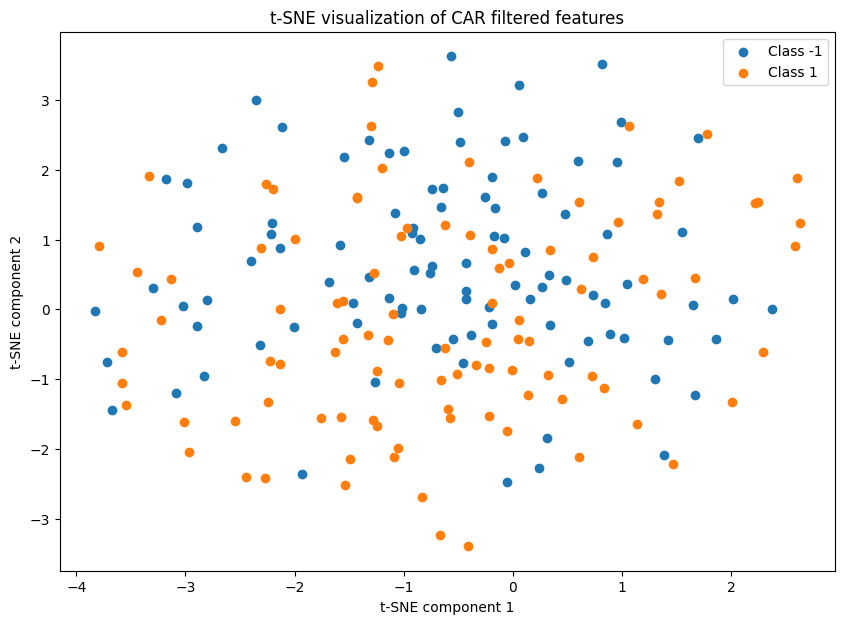

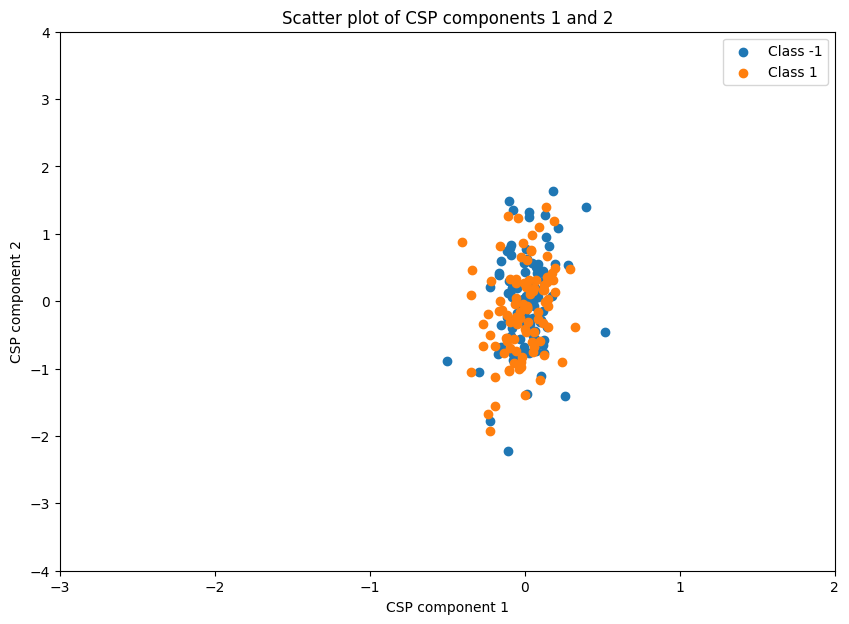

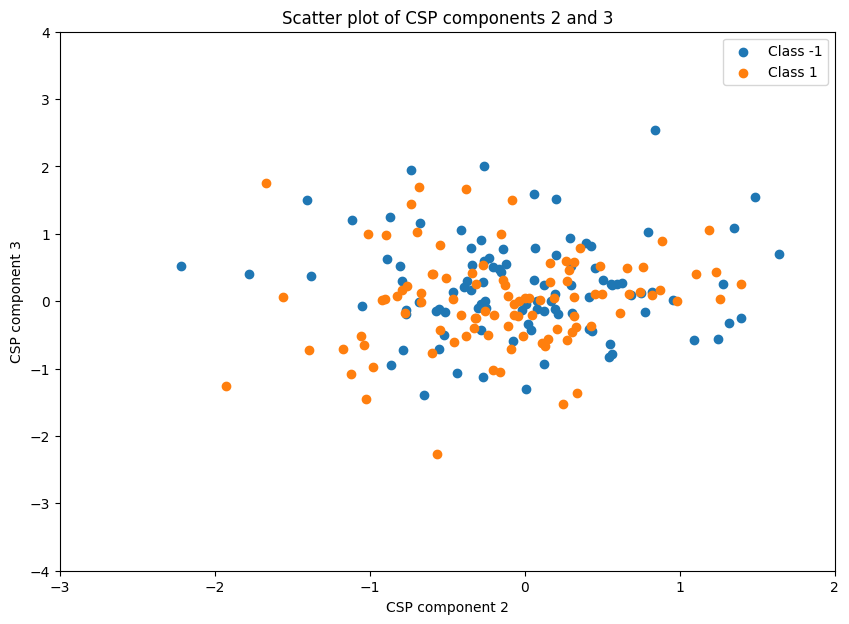

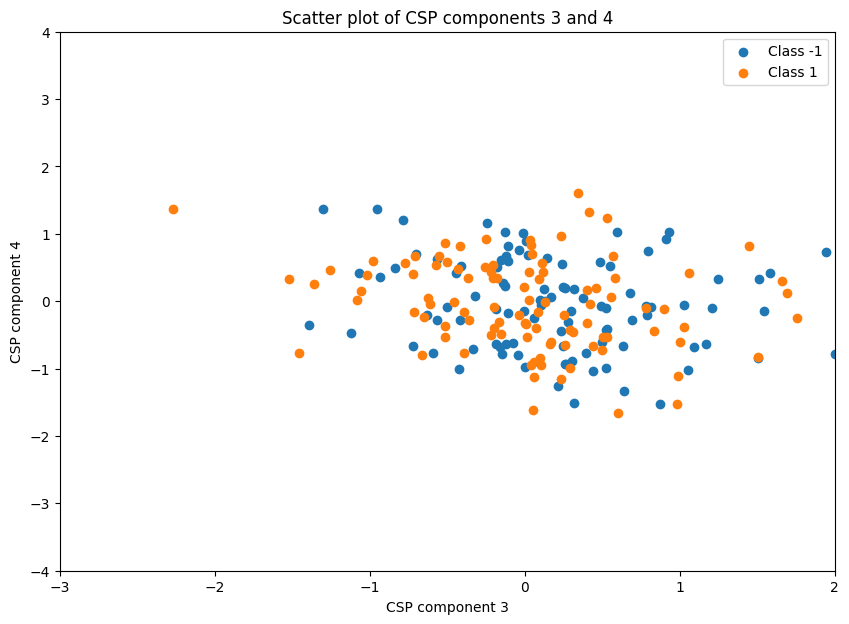

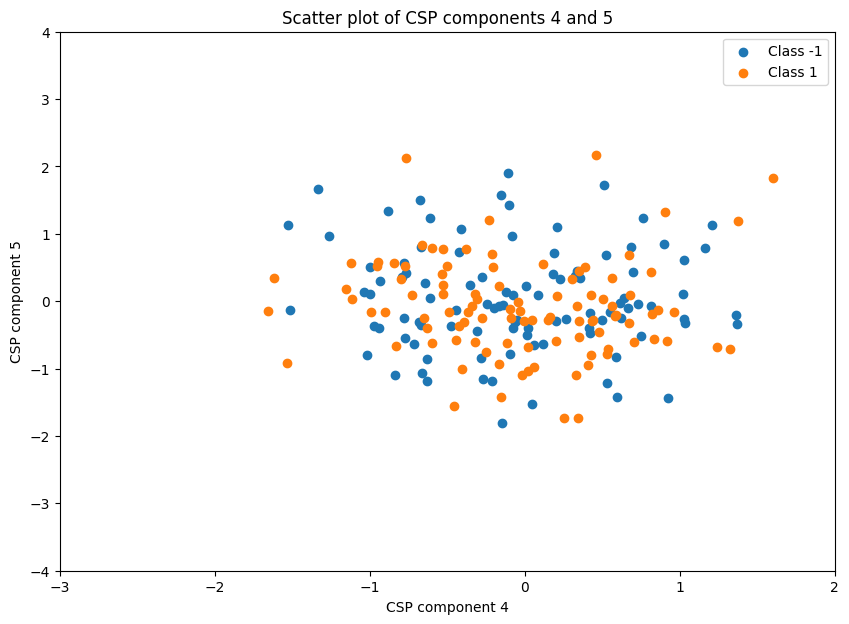

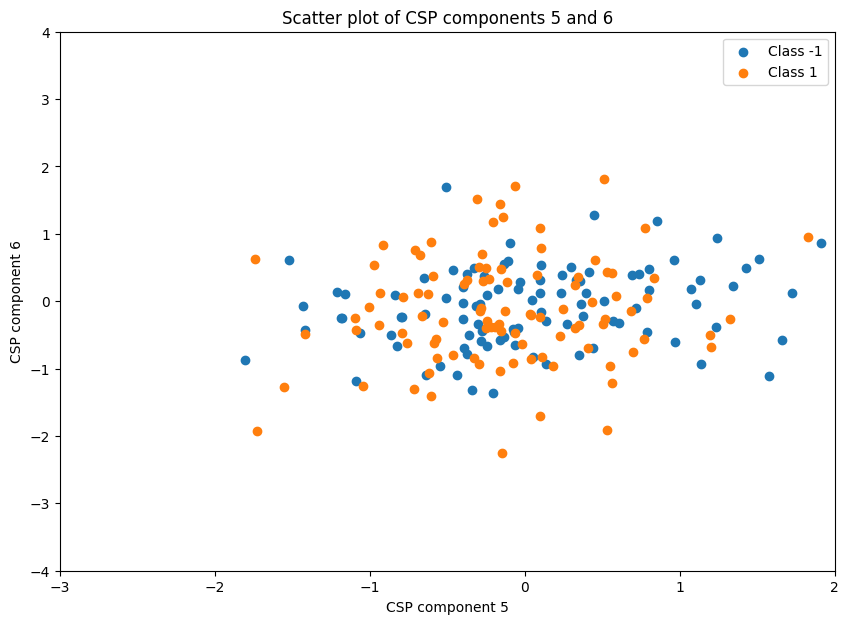

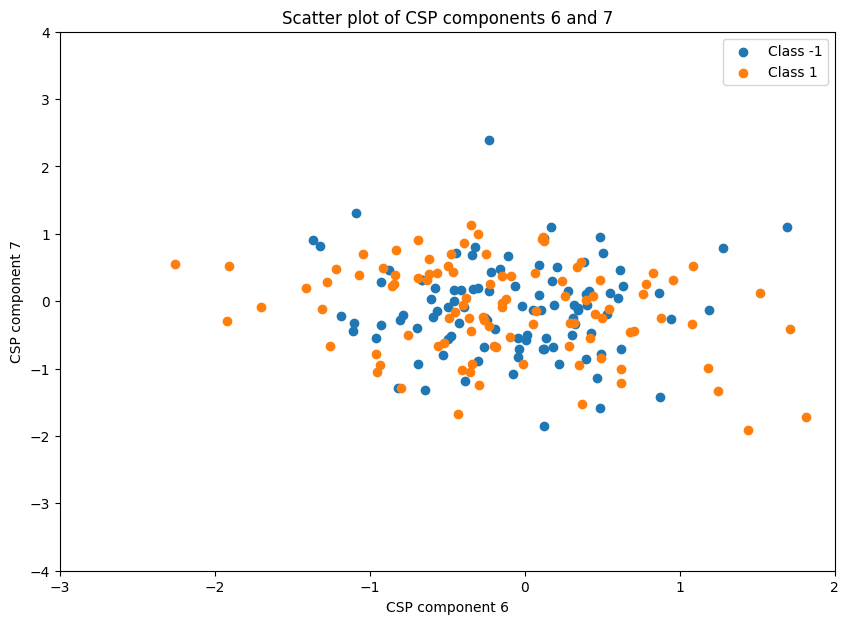

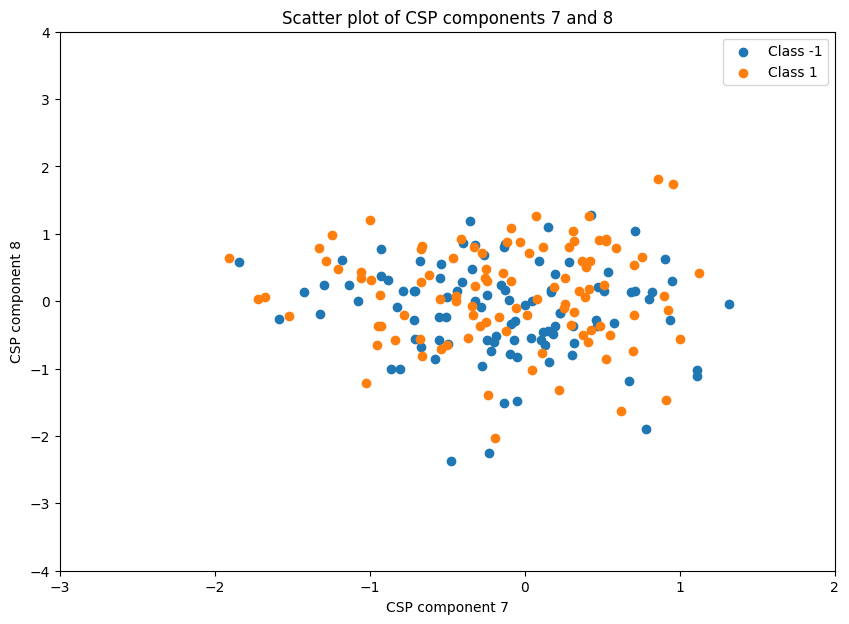

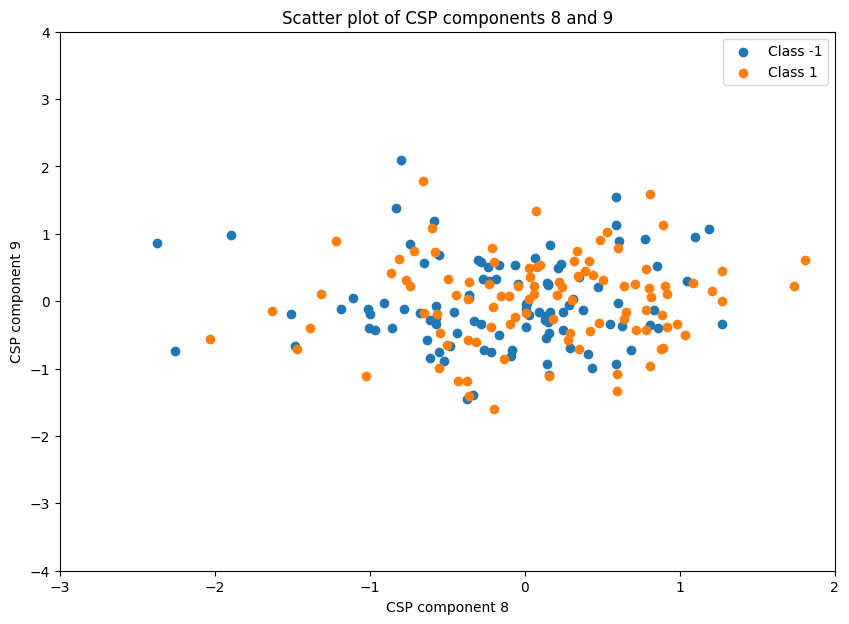

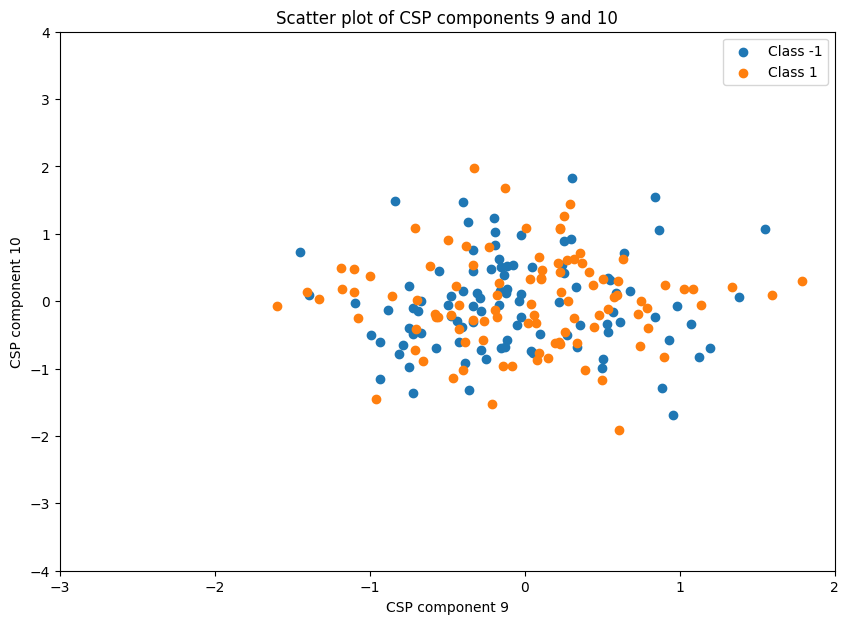

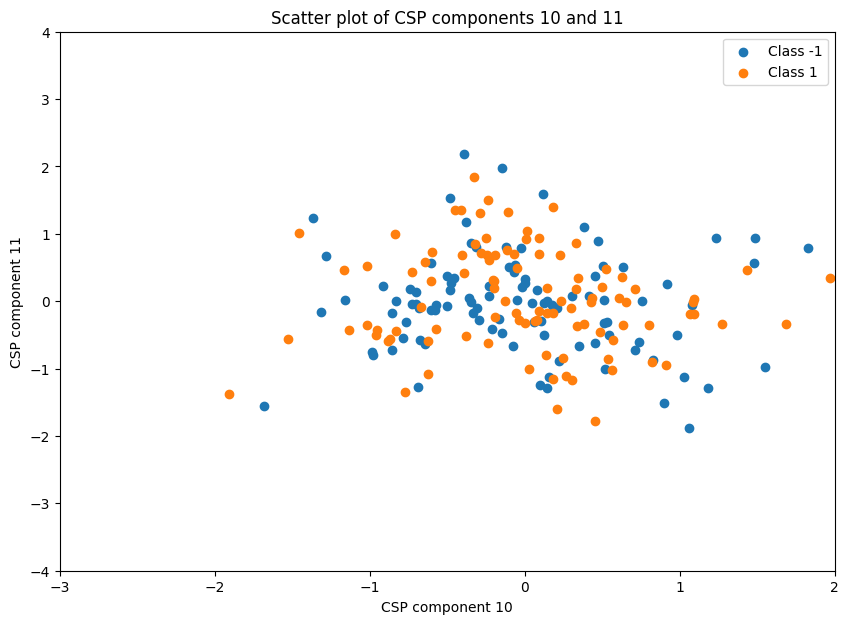

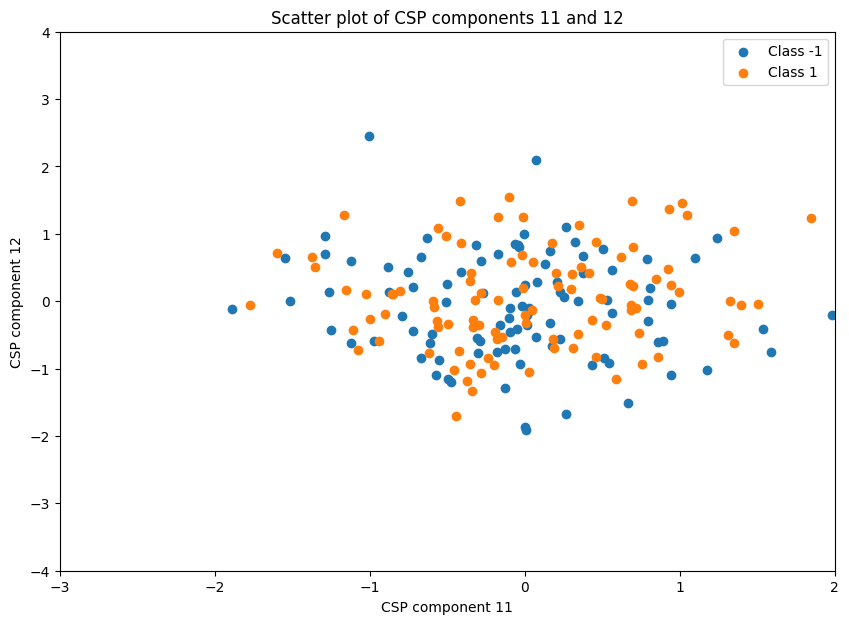

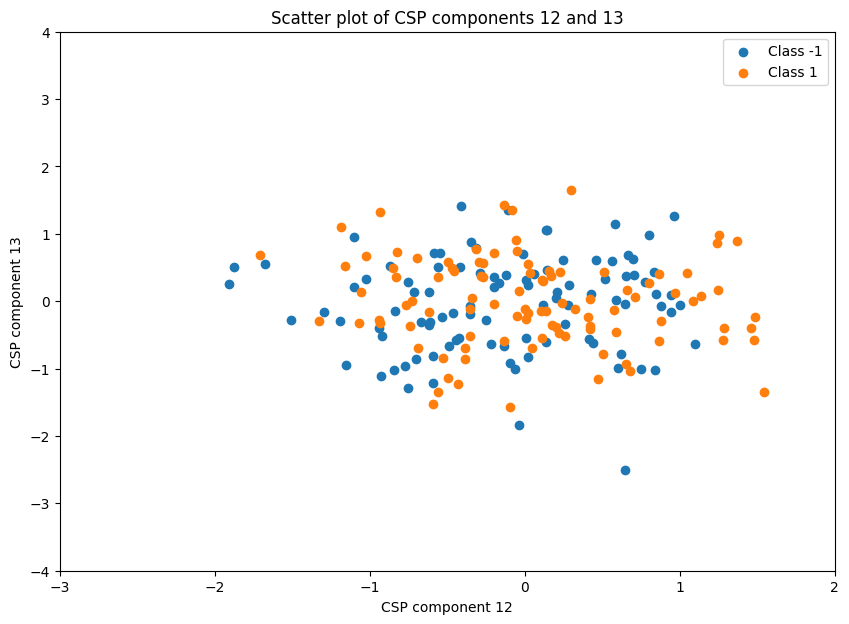

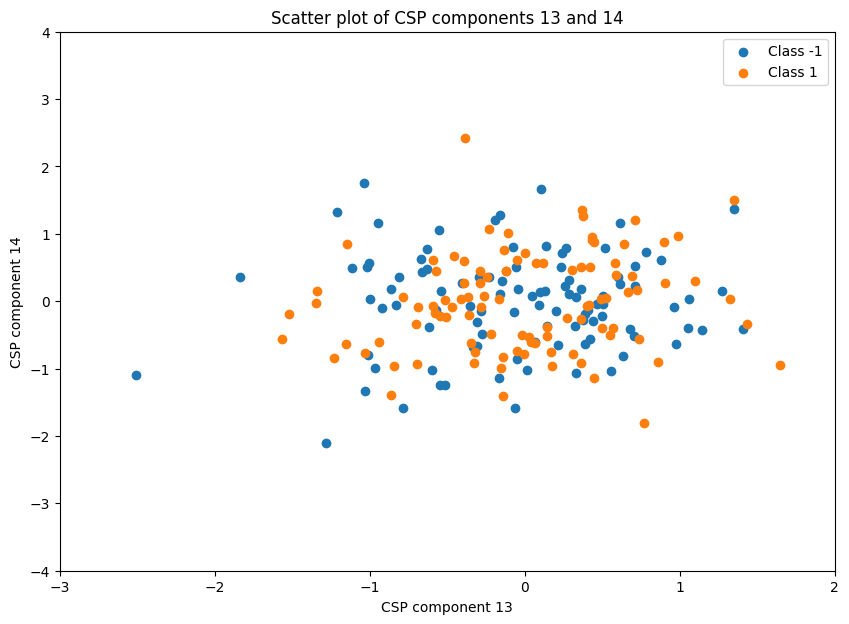

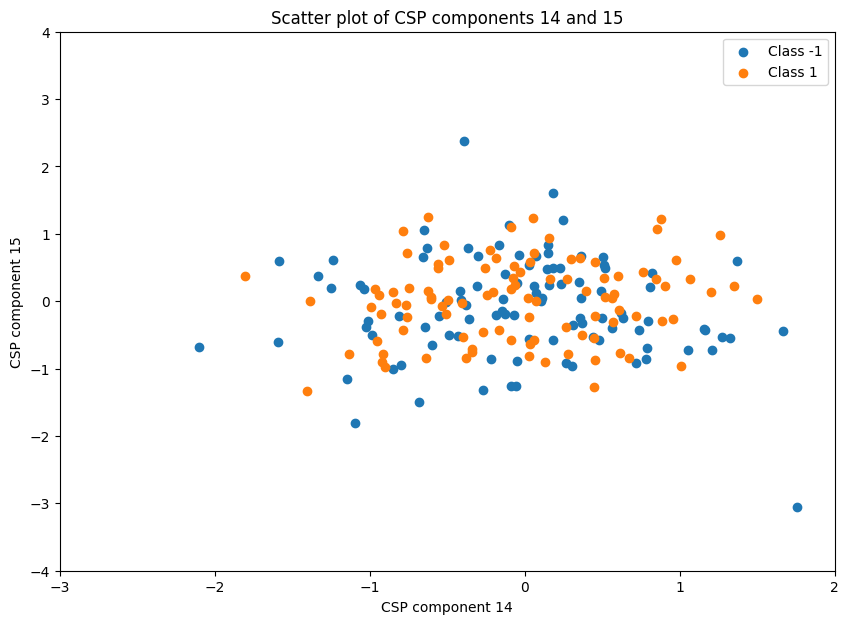

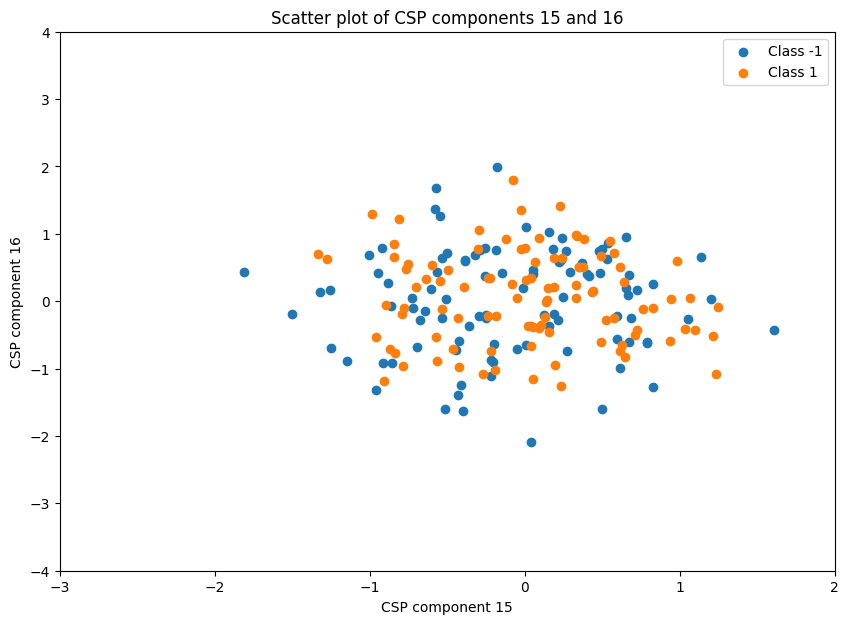

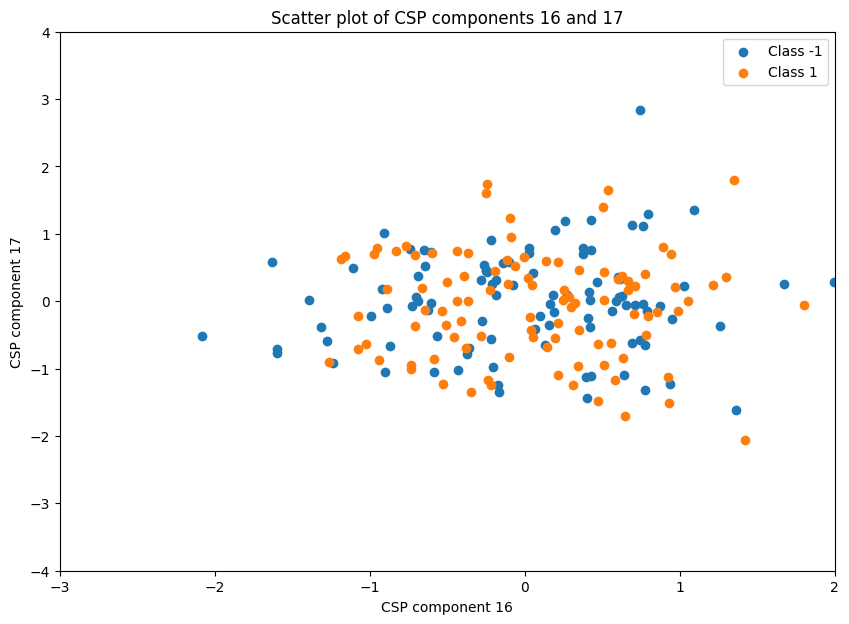

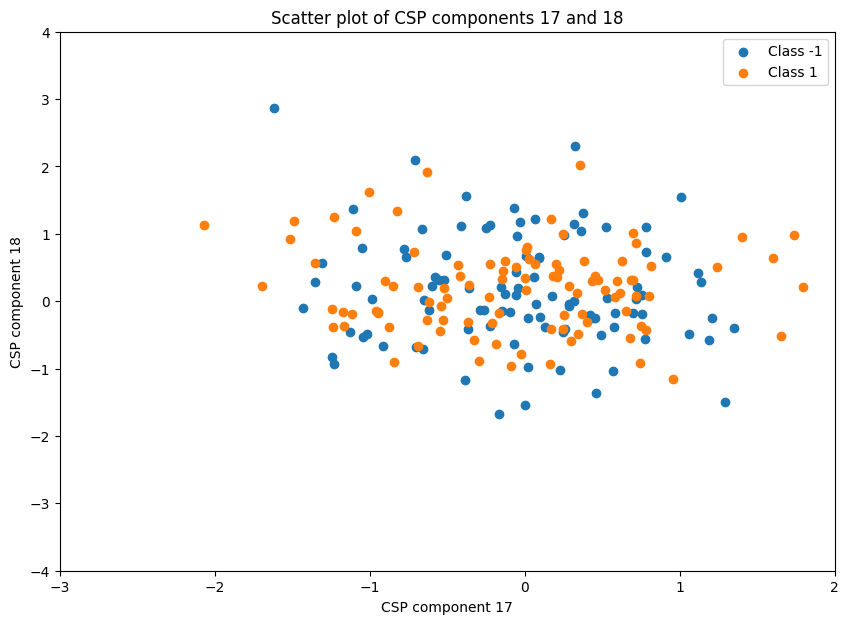

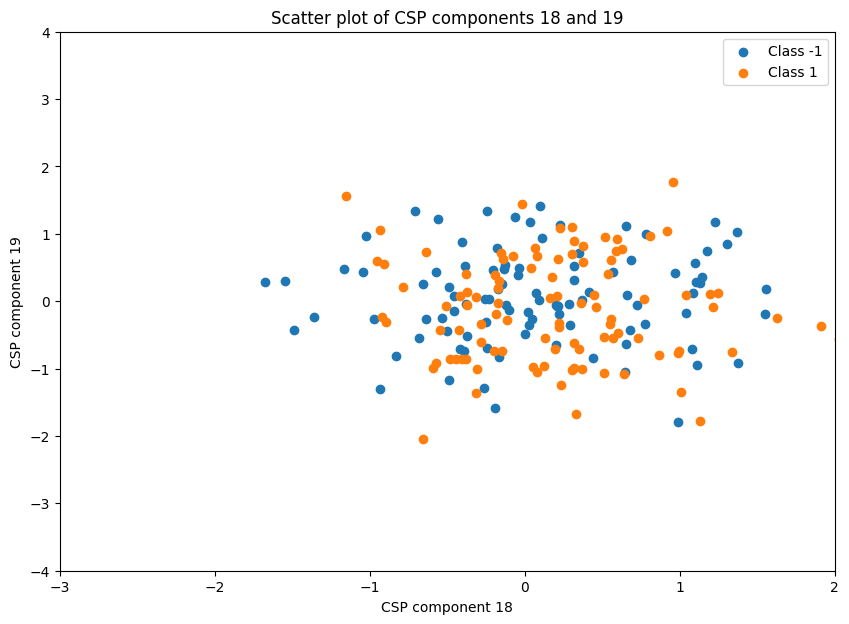

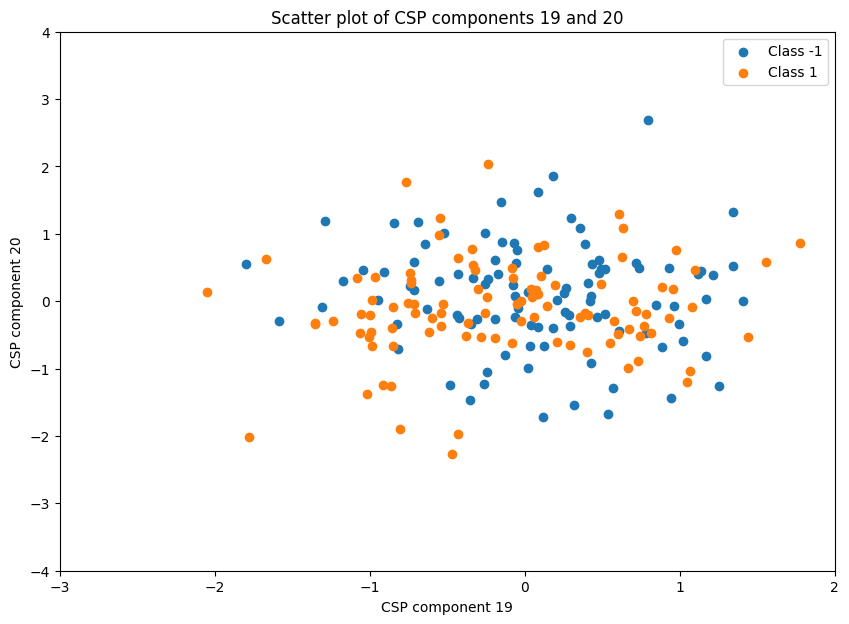

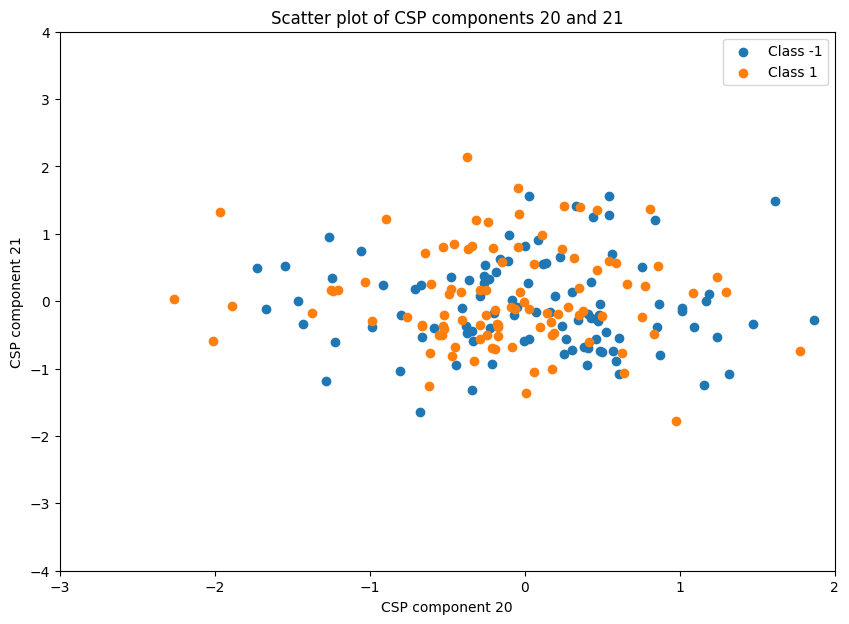

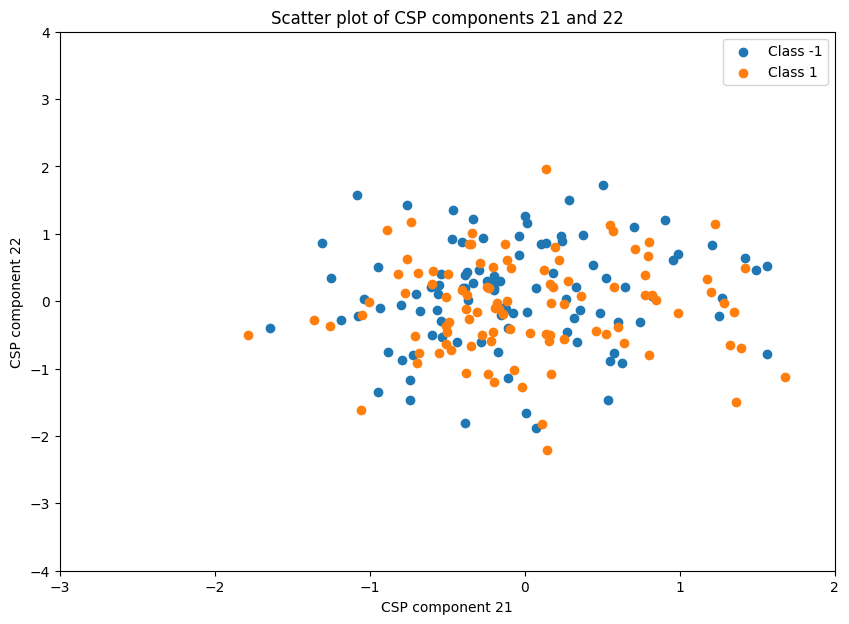

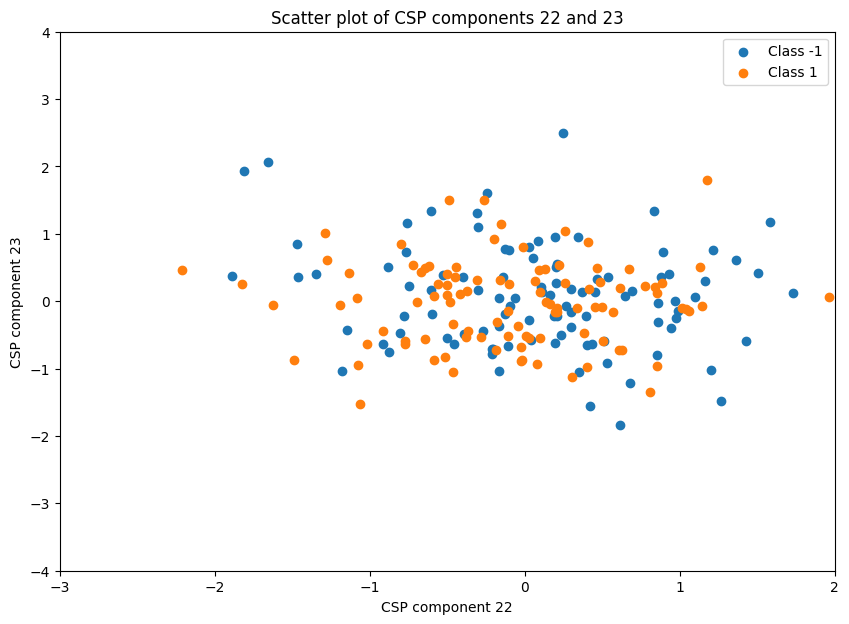

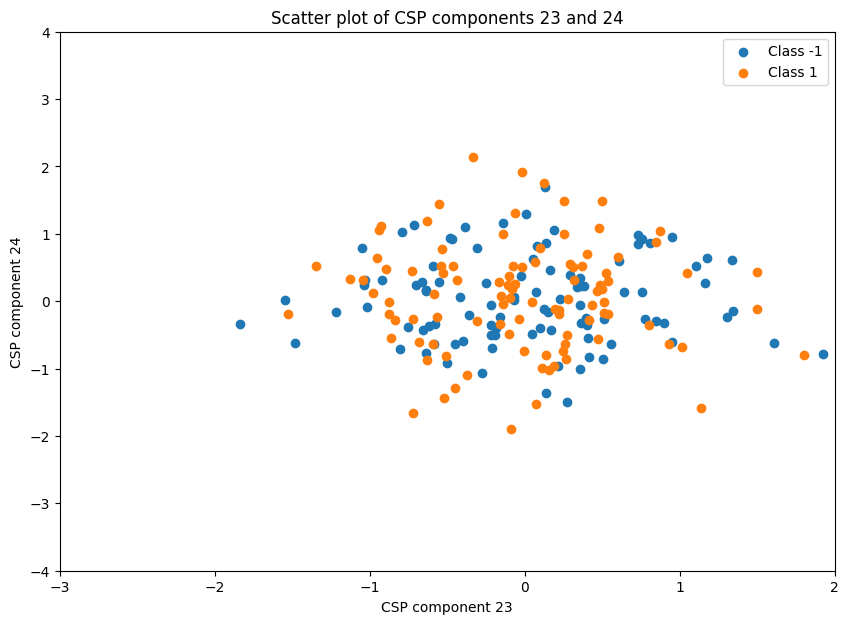

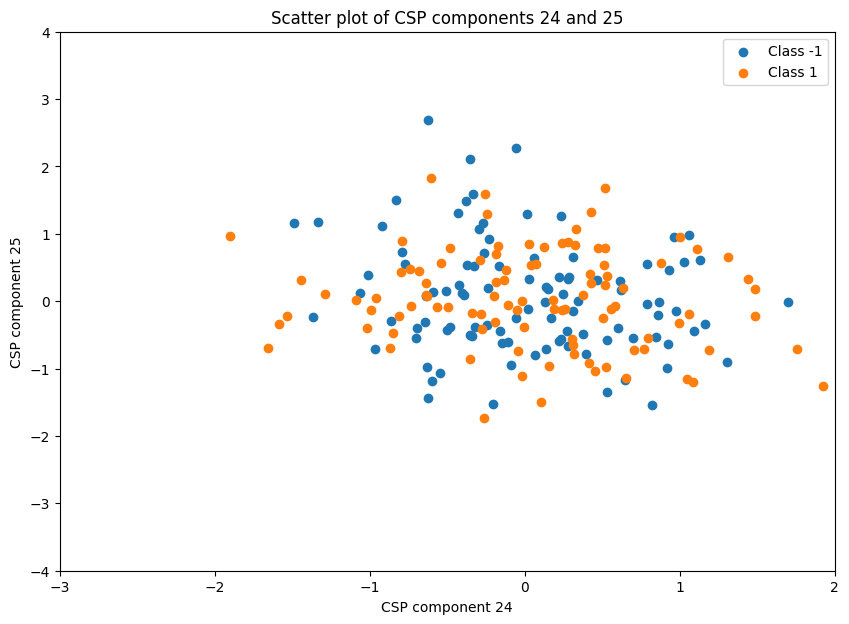

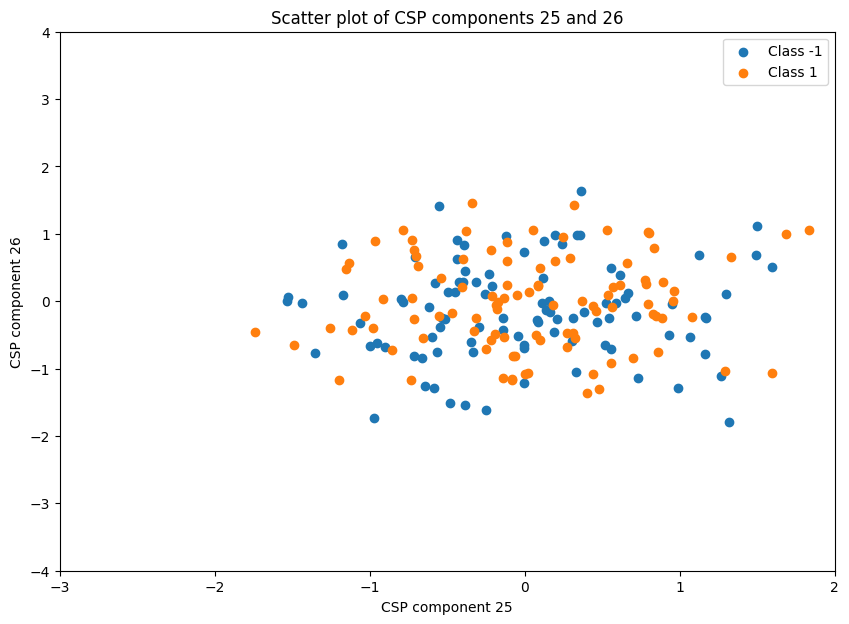

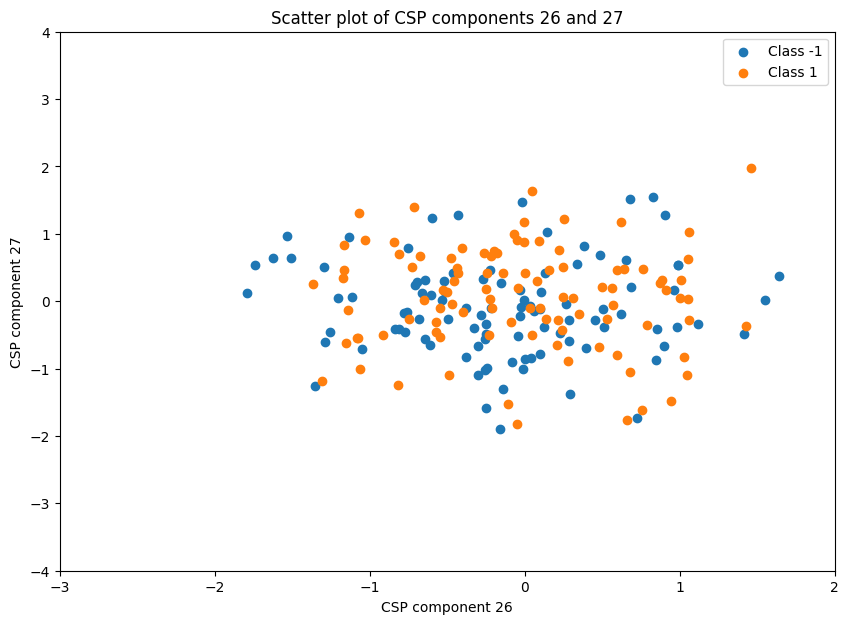

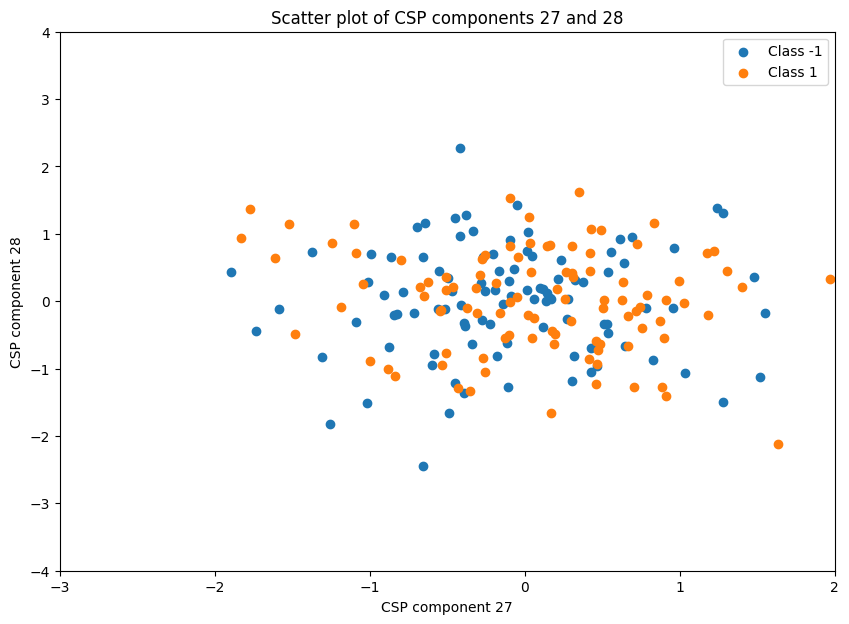

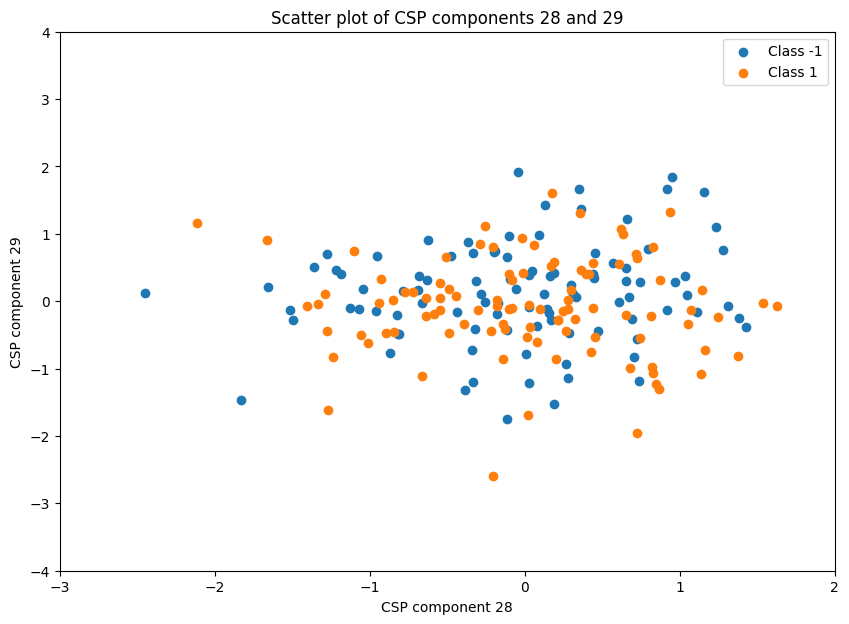

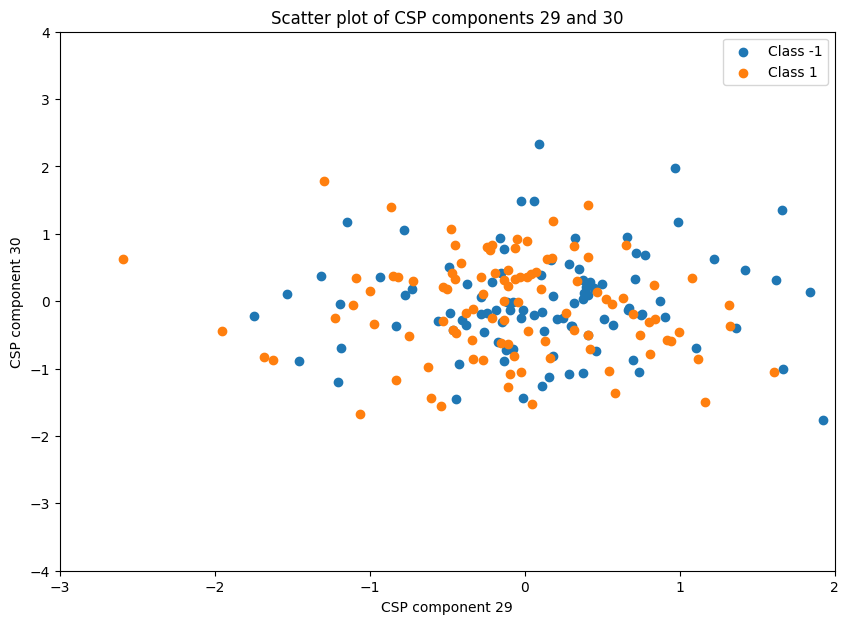

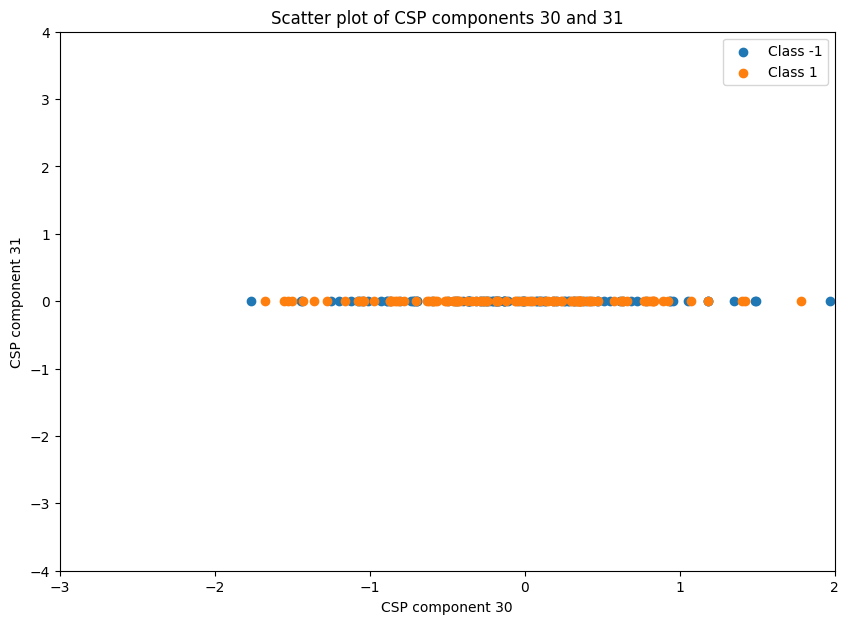

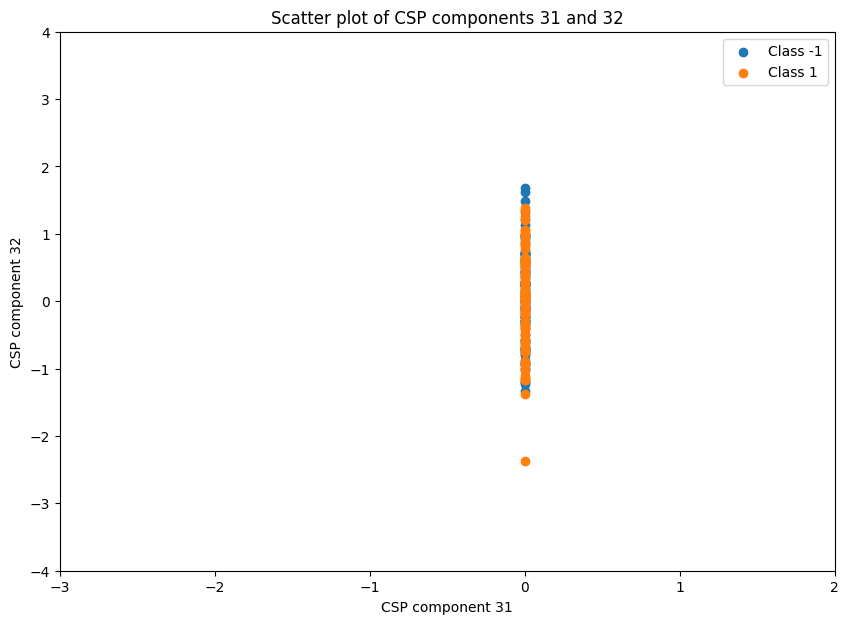

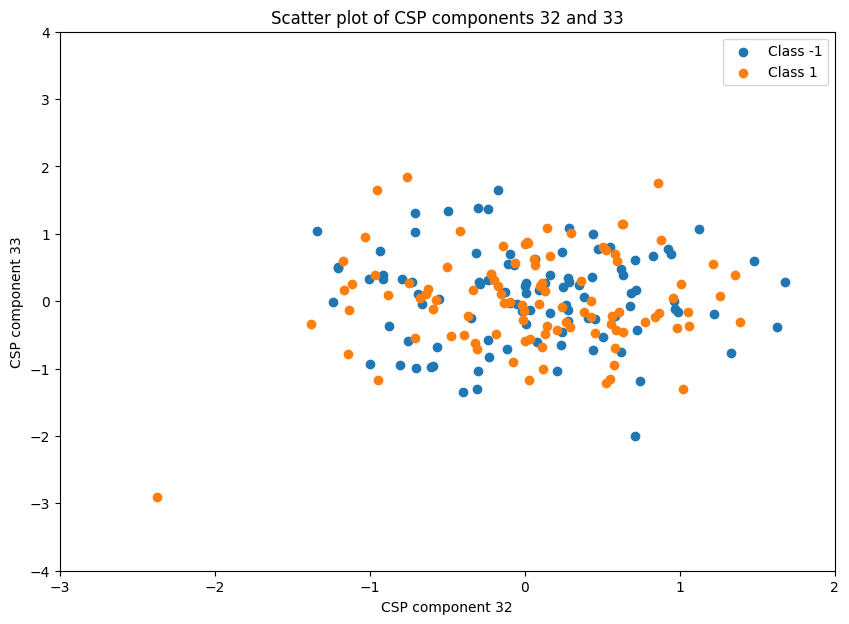

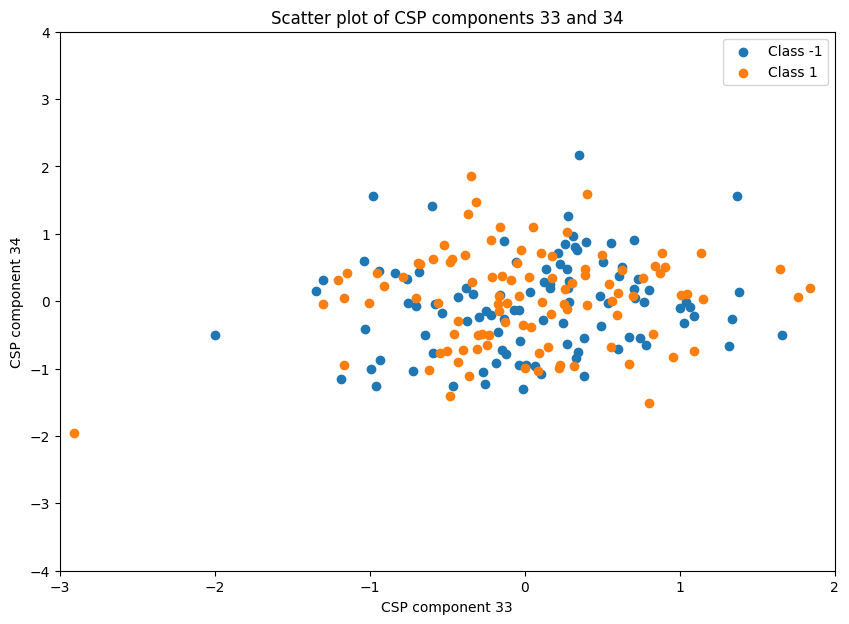

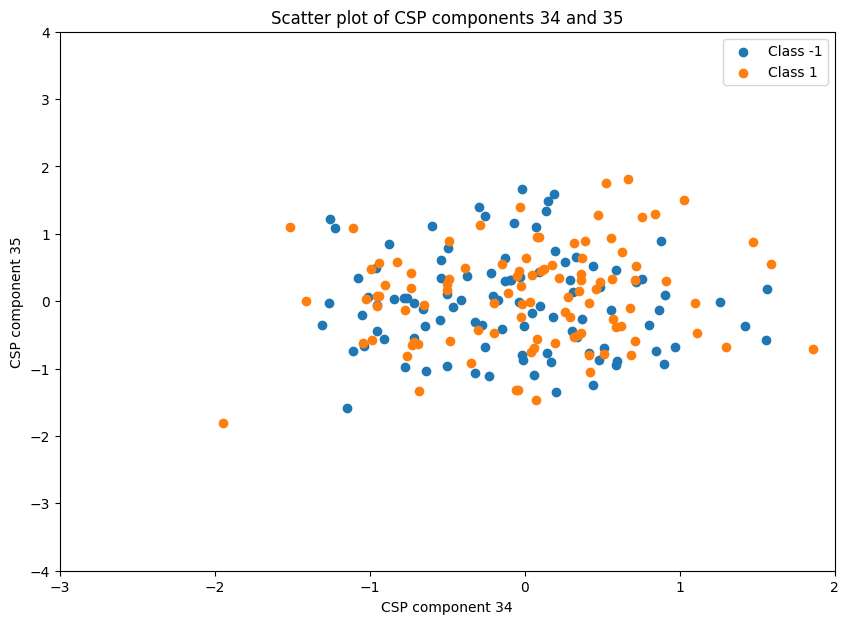

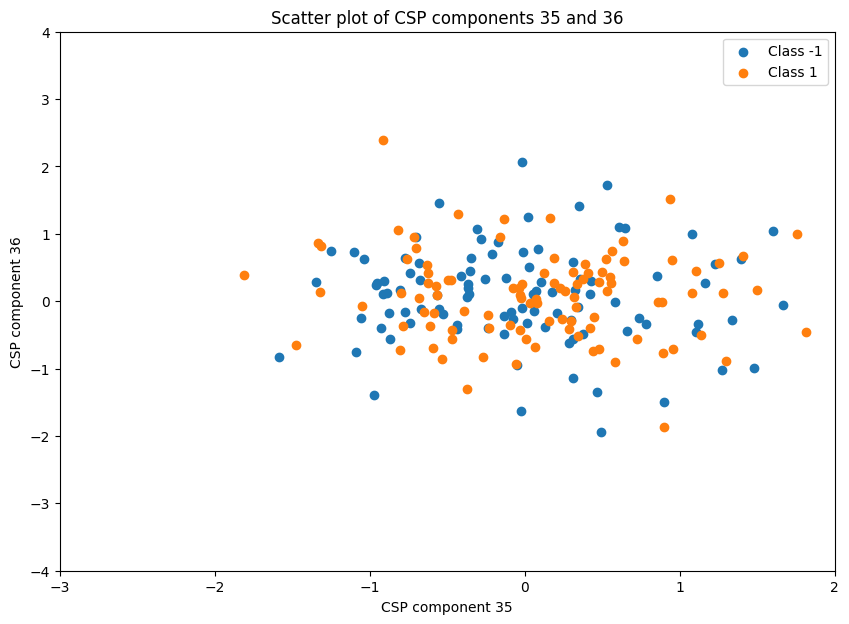

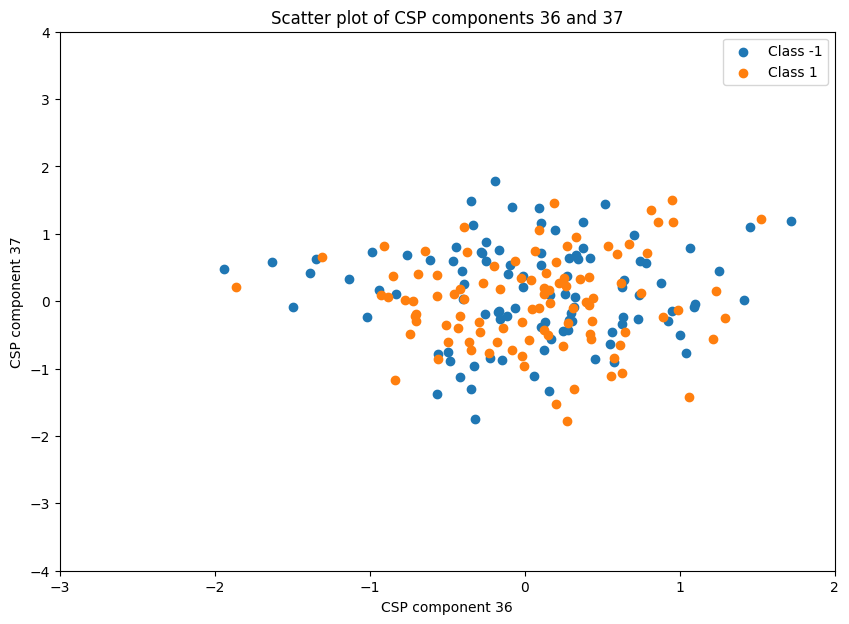

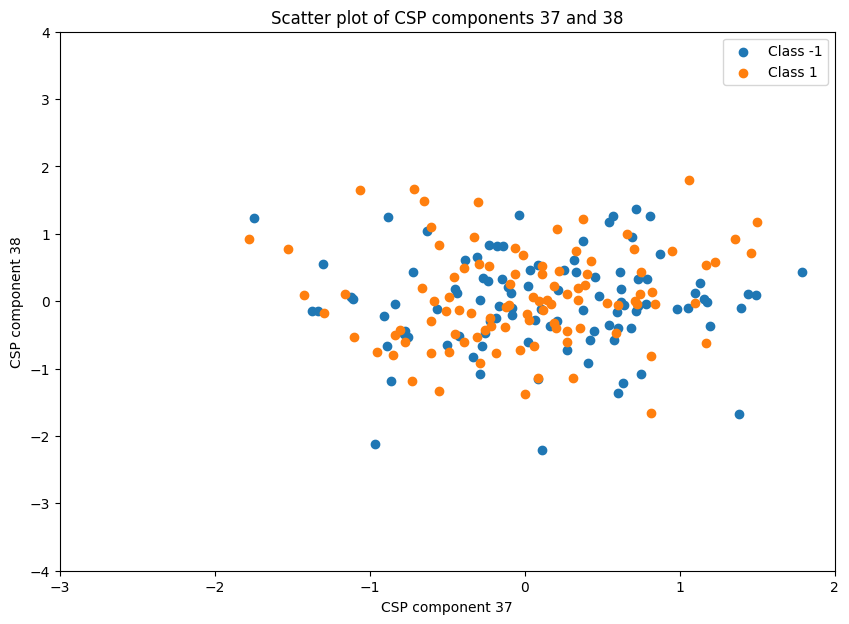

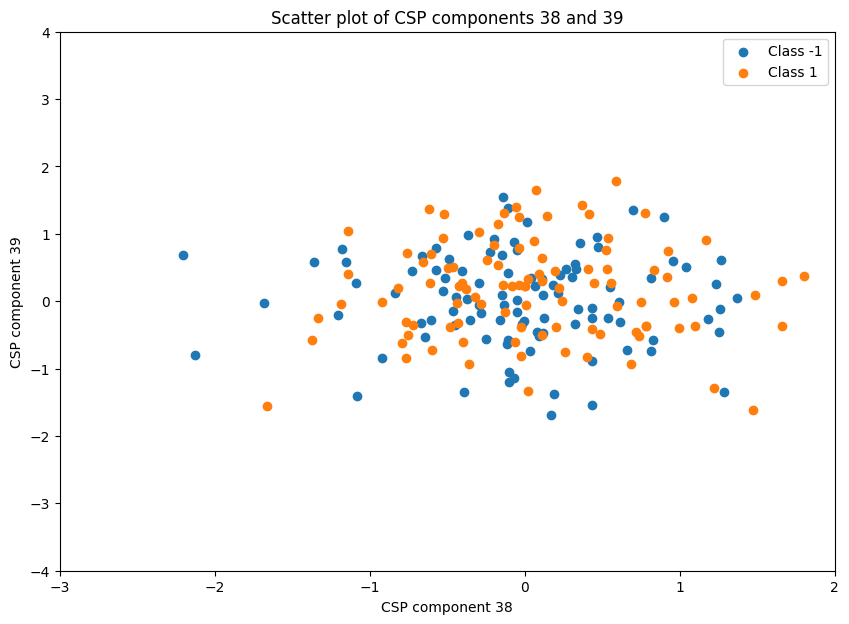

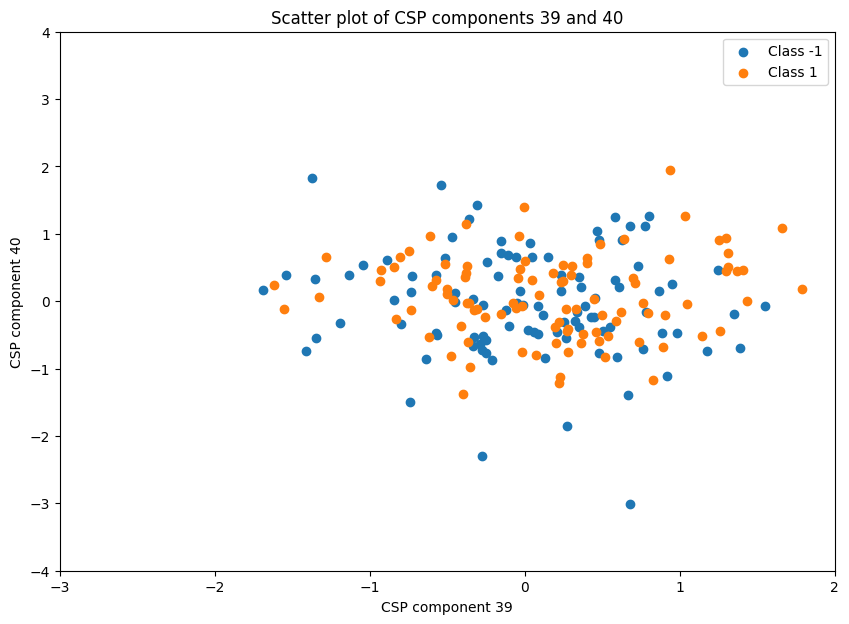

KNN Confusion Matrix:
 [[25  0]
 [25  0]]
KNN Classification Report:
               precision    recall  f1-score   support

          -1       0.50      1.00      0.67        25
           1       0.00      0.00      0.00        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


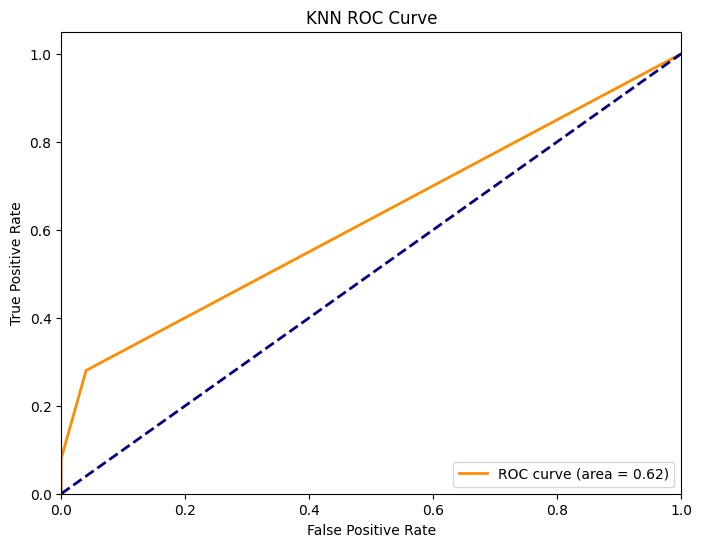

SVM Confusion Matrix:
 [[15 10]
 [14 11]]
SVM Classification Report:
               precision    recall  f1-score   support

          -1       0.52      0.60      0.56        25
           1       0.52      0.44      0.48        25

    accuracy                           0.52        50
   macro avg       0.52      0.52      0.52        50
weighted avg       0.52      0.52      0.52        50



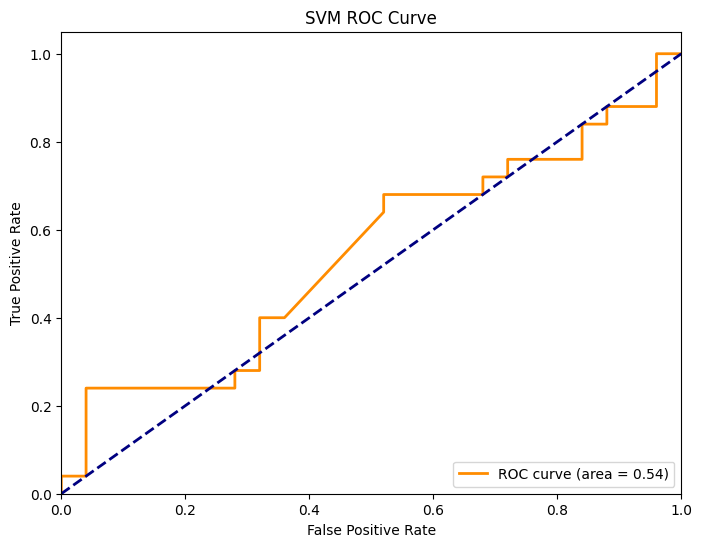

MLP Confusion Matrix:
 [[16  9]
 [16  9]]
MLP Classification Report:
               precision    recall  f1-score   support

          -1       0.50      0.64      0.56        25
           1       0.50      0.36      0.42        25

    accuracy                           0.50        50
   macro avg       0.50      0.50      0.49        50
weighted avg       0.50      0.50      0.49        50



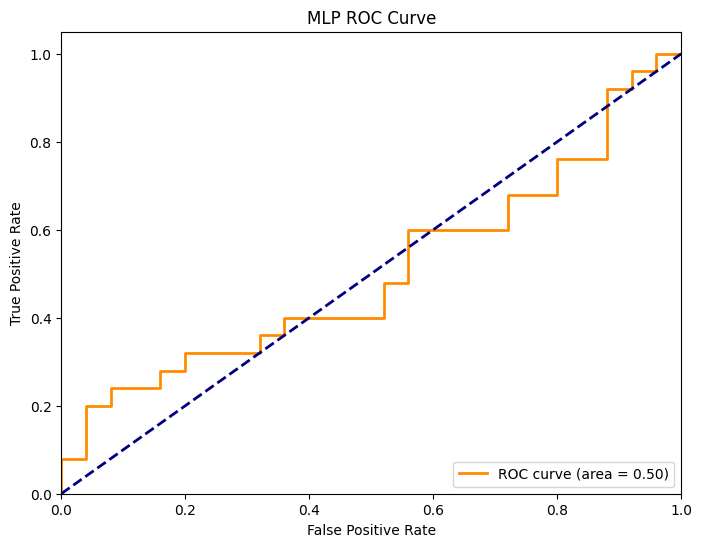

AdaBoost Confusion Matrix:
 [[18  7]
 [10 15]]
AdaBoost Classification Report:
               precision    recall  f1-score   support

          -1       0.64      0.72      0.68        25
           1       0.68      0.60      0.64        25

    accuracy                           0.66        50
   macro avg       0.66      0.66      0.66        50
weighted avg       0.66      0.66      0.66        50



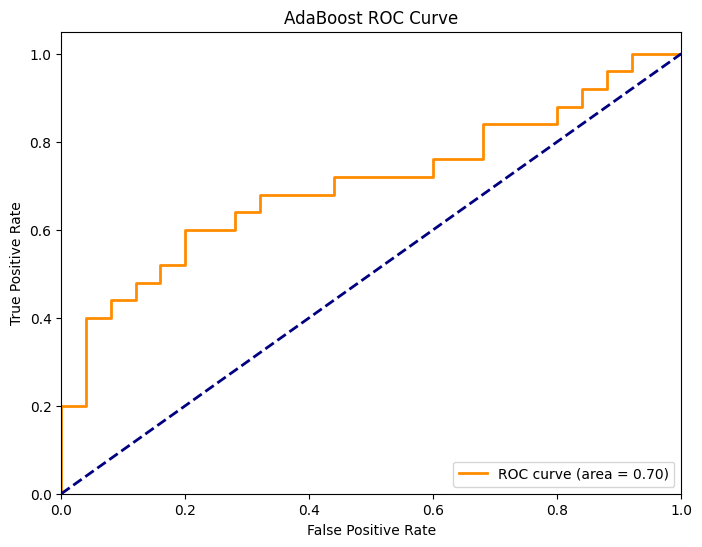

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

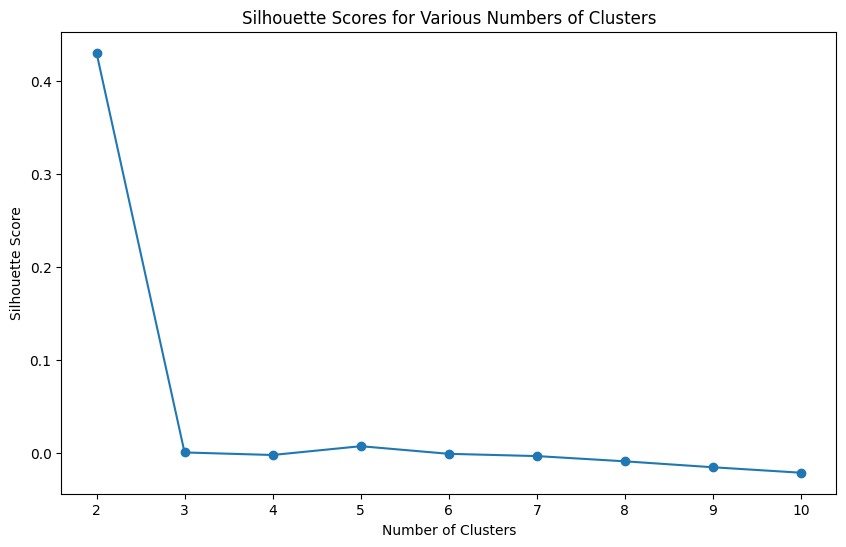

Optimal number of clusters: 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Silhouette Score: 0.4308579729694514


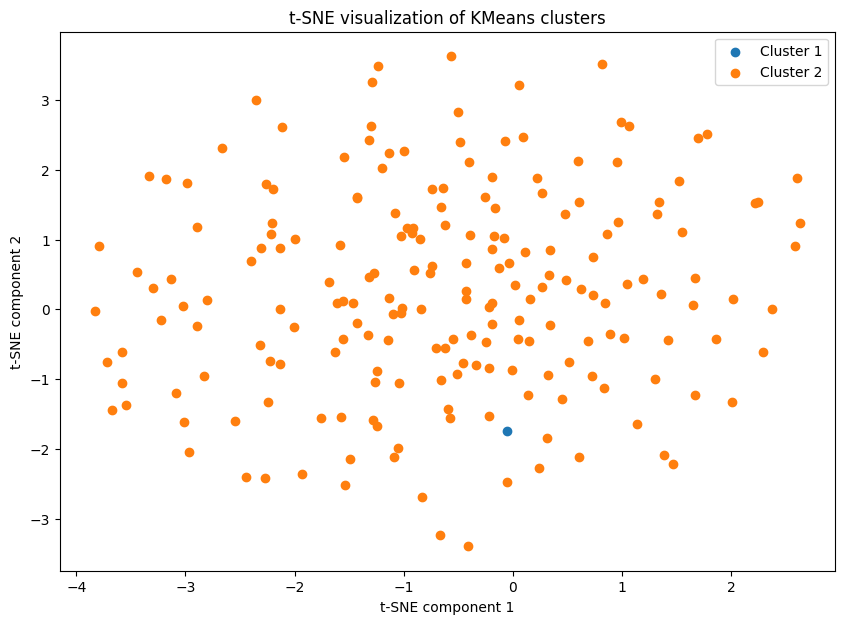

AgglomerativeClustering Silhouette Score: 0.4308579729694514


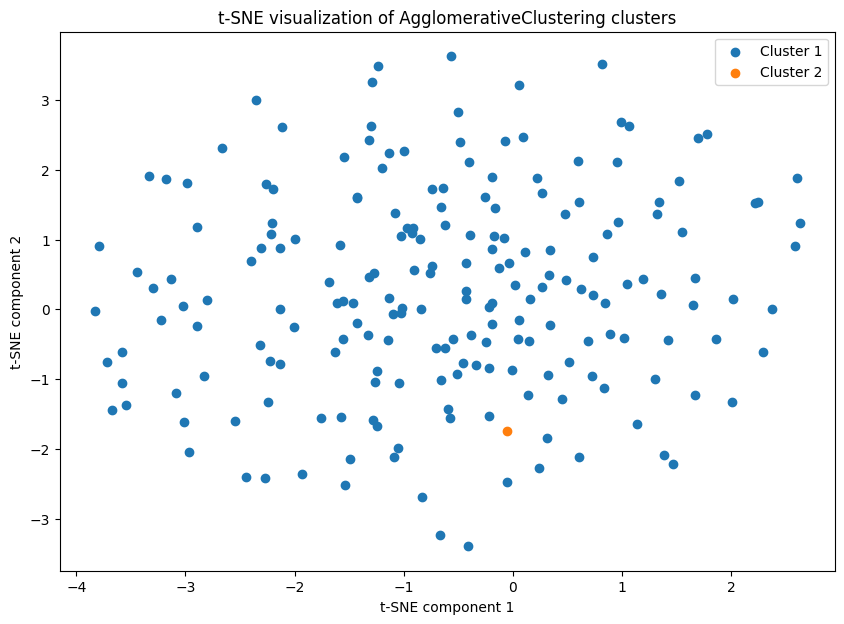

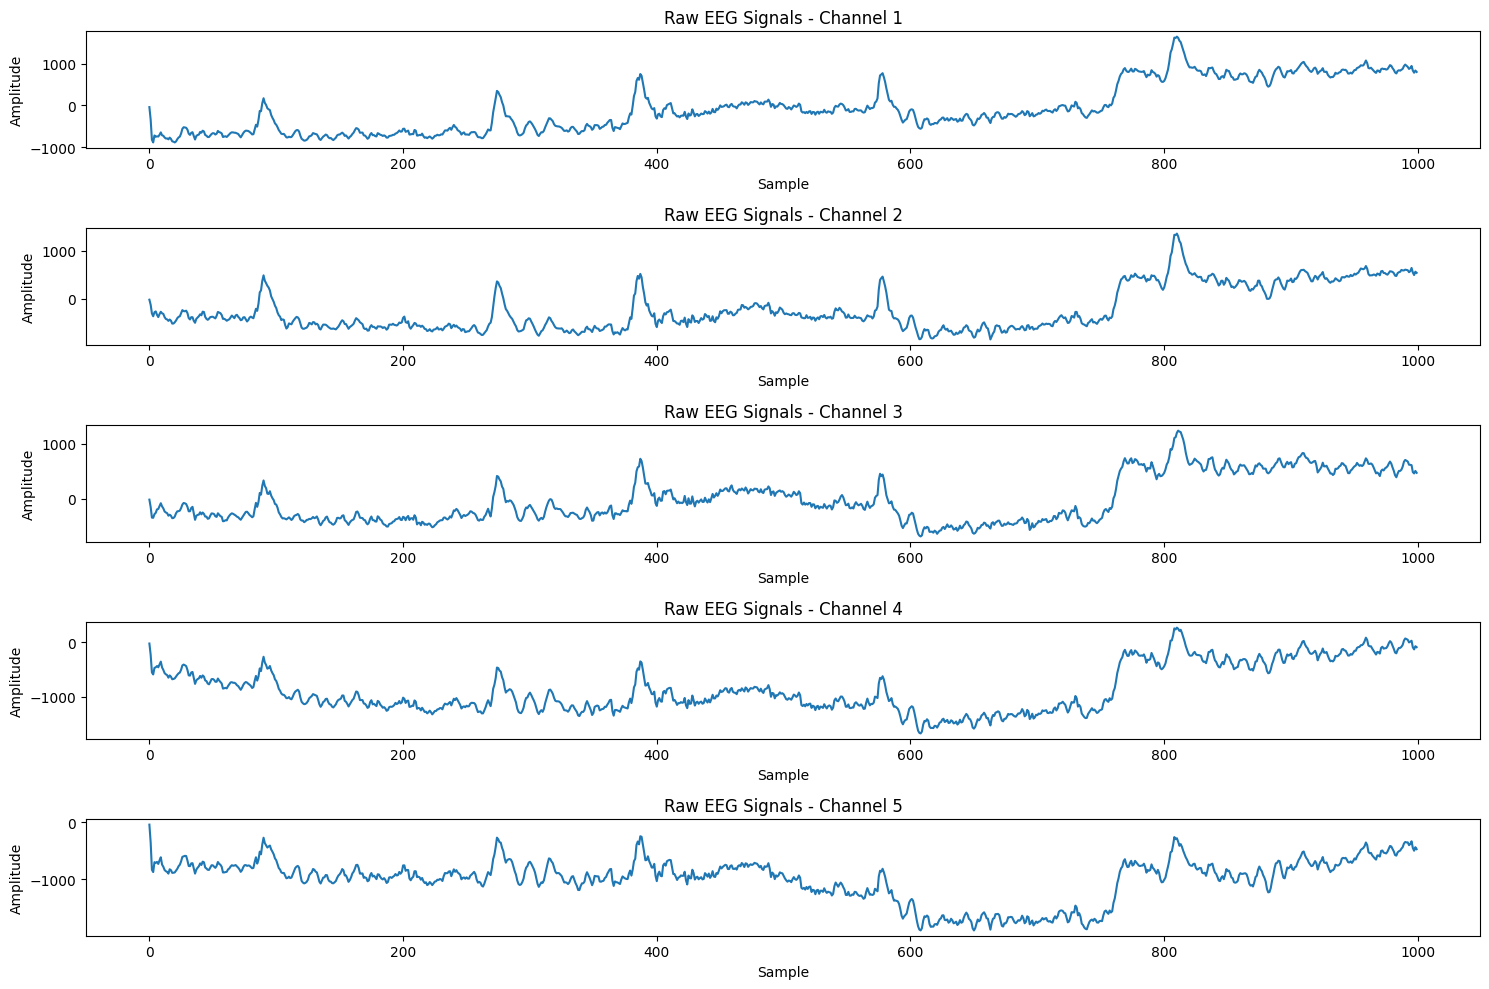

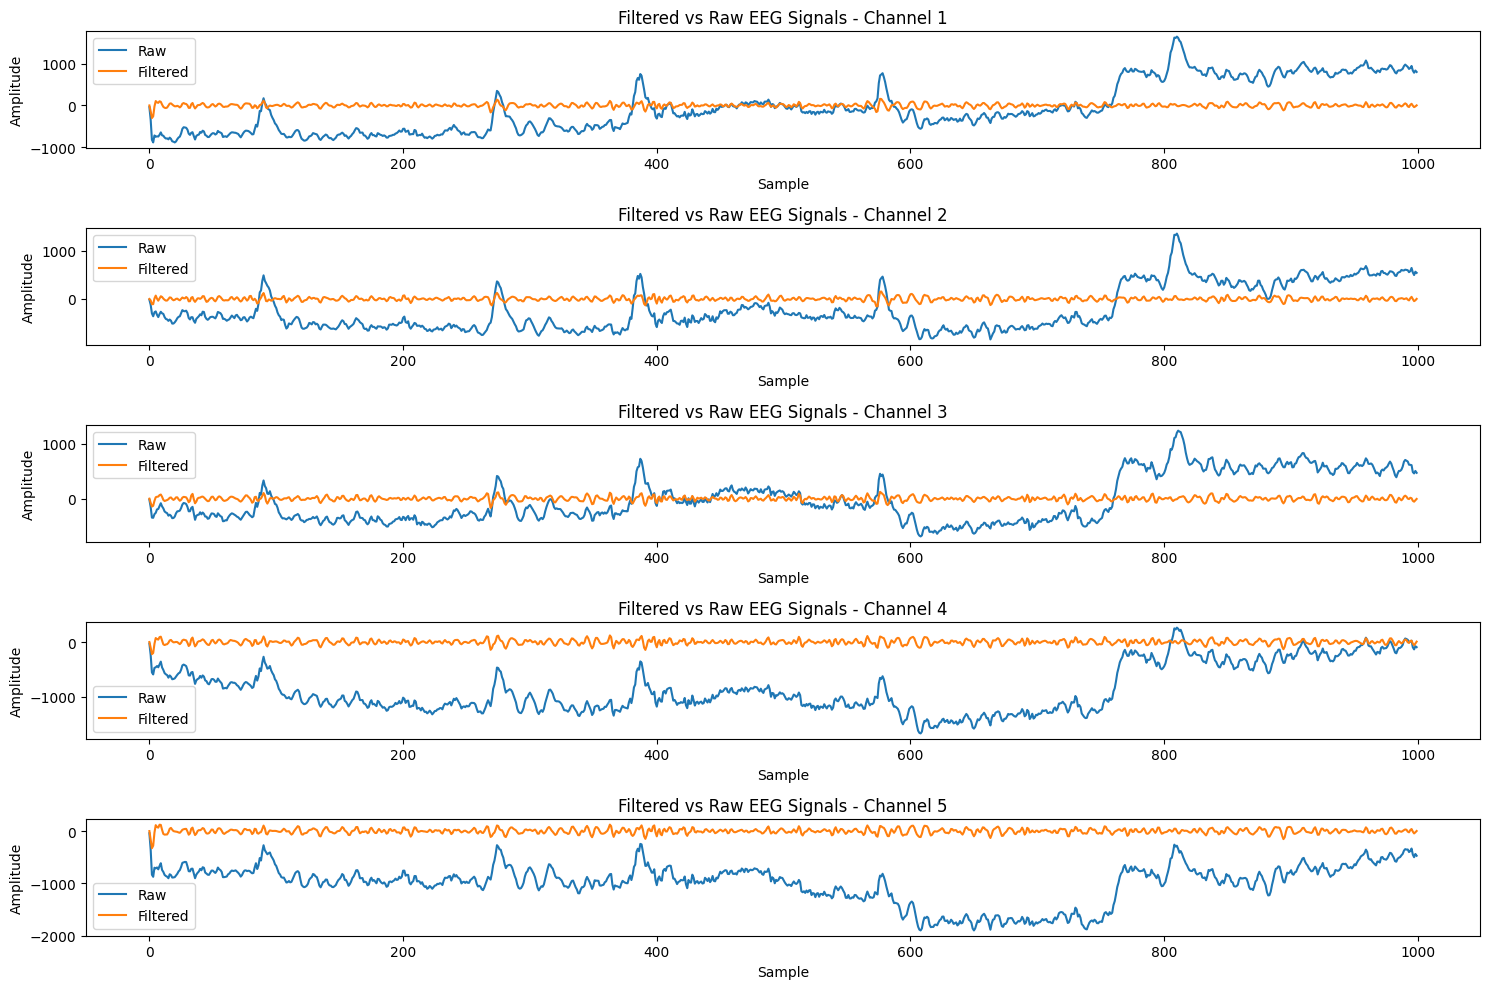

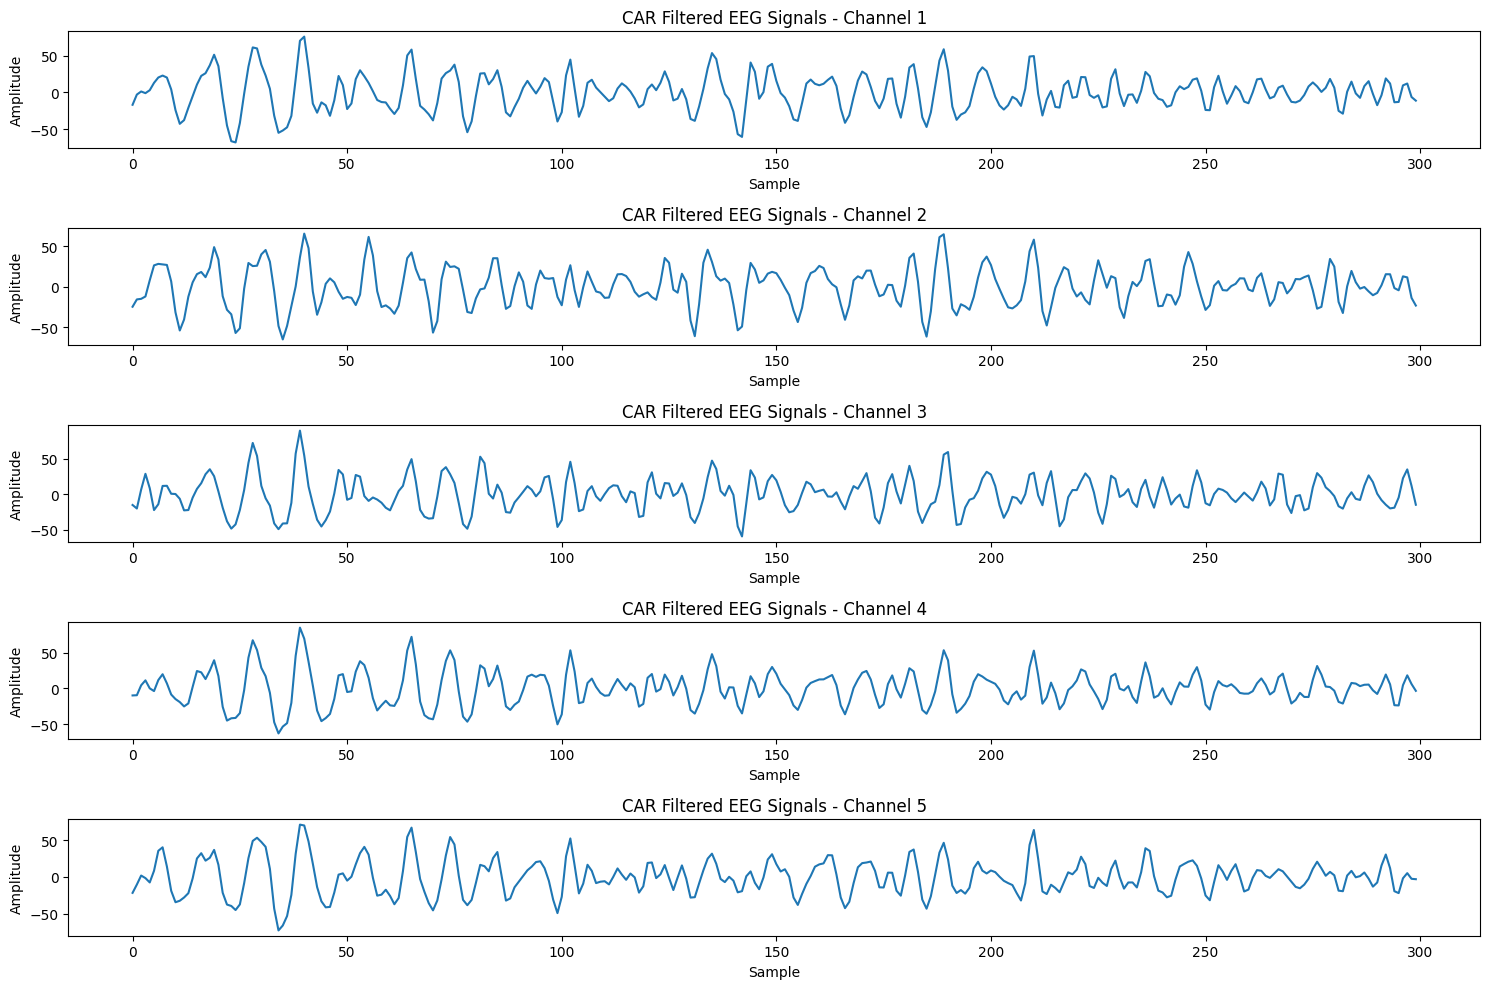

<ipython-input-30-06189f19bbf7>:147: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


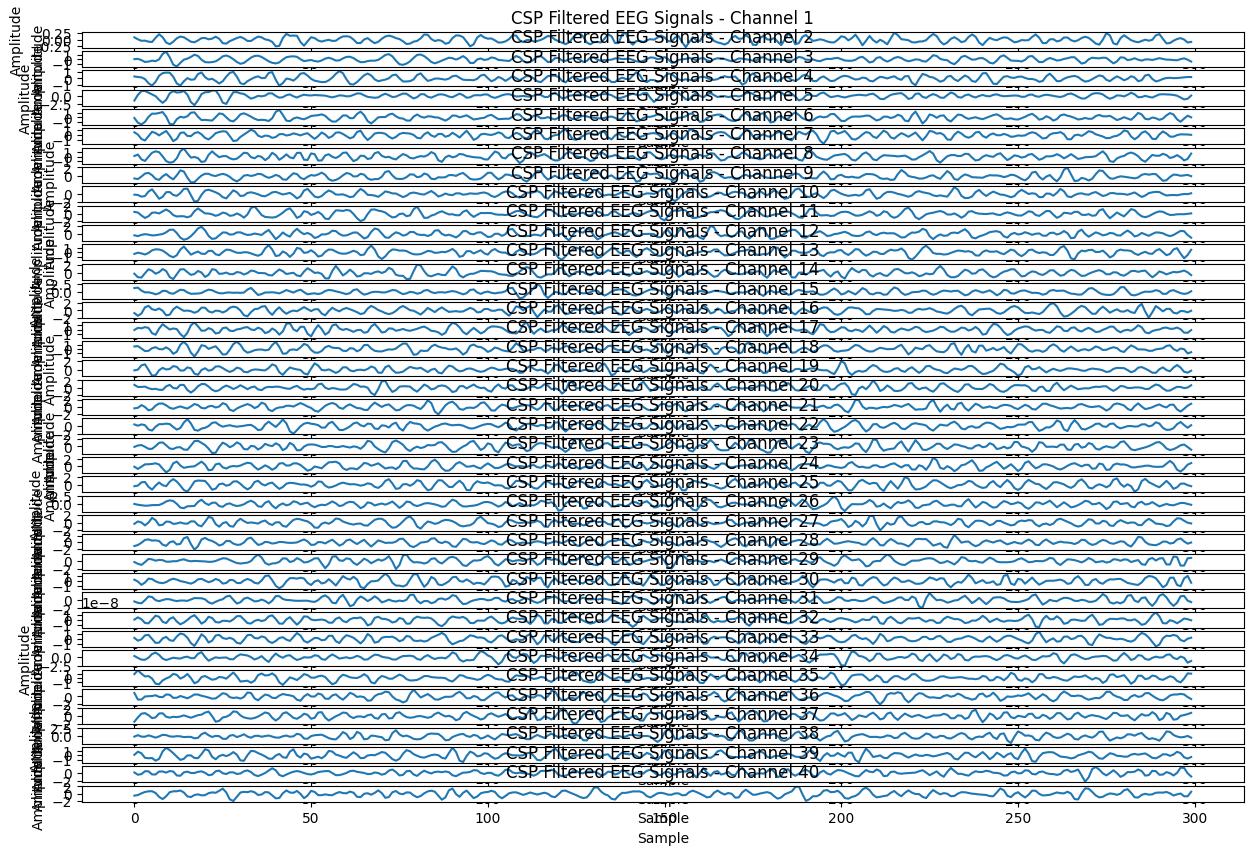

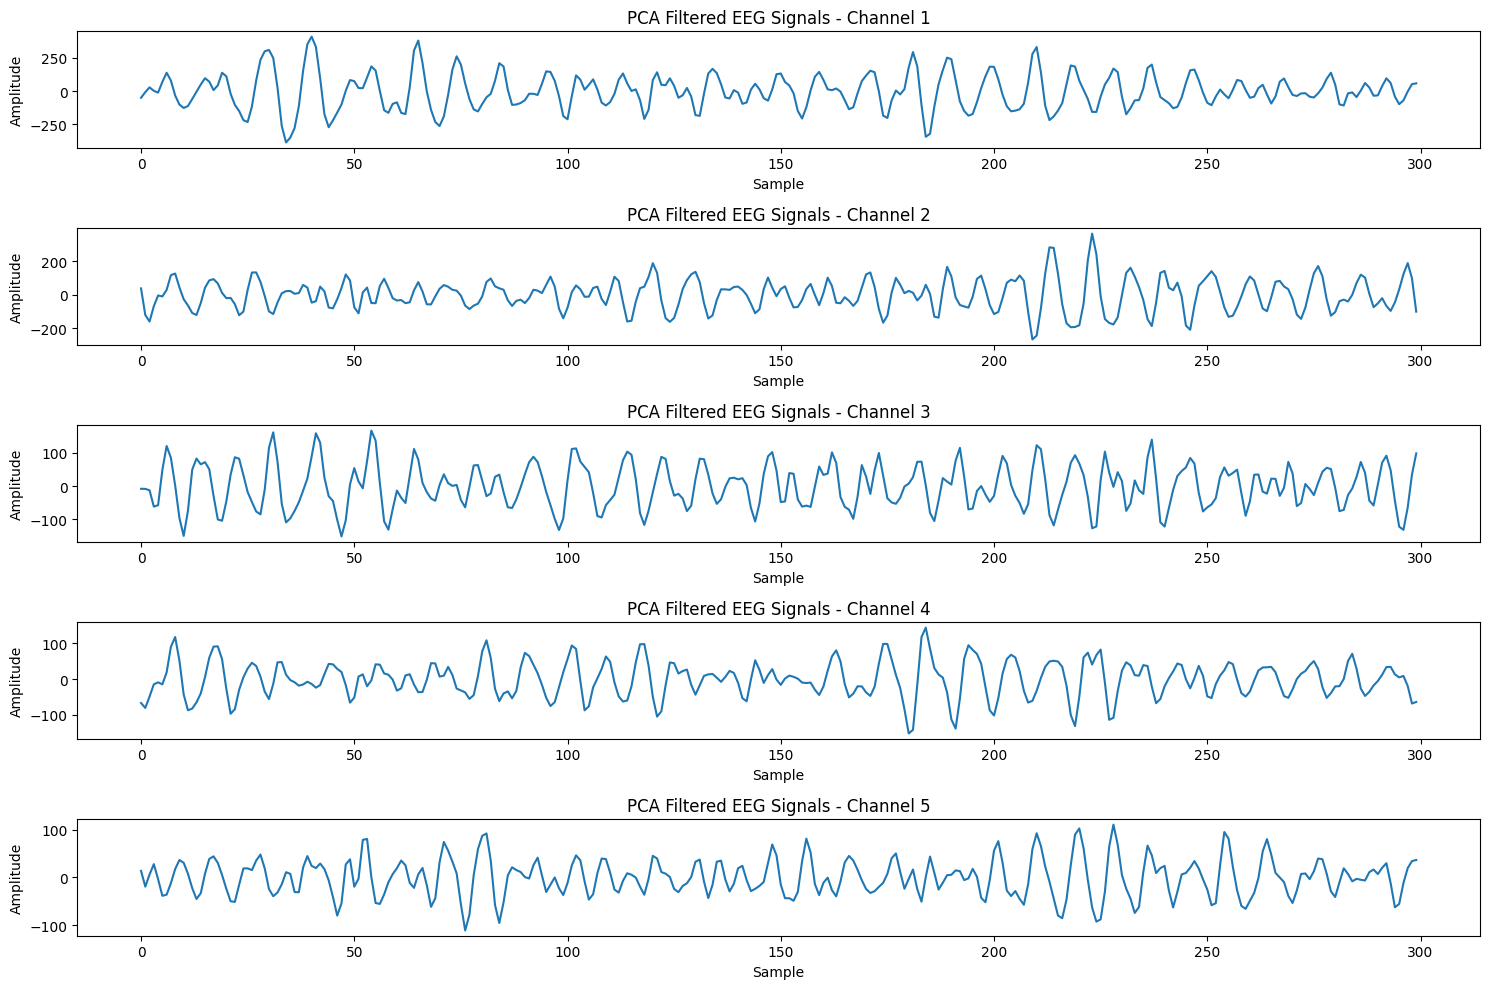

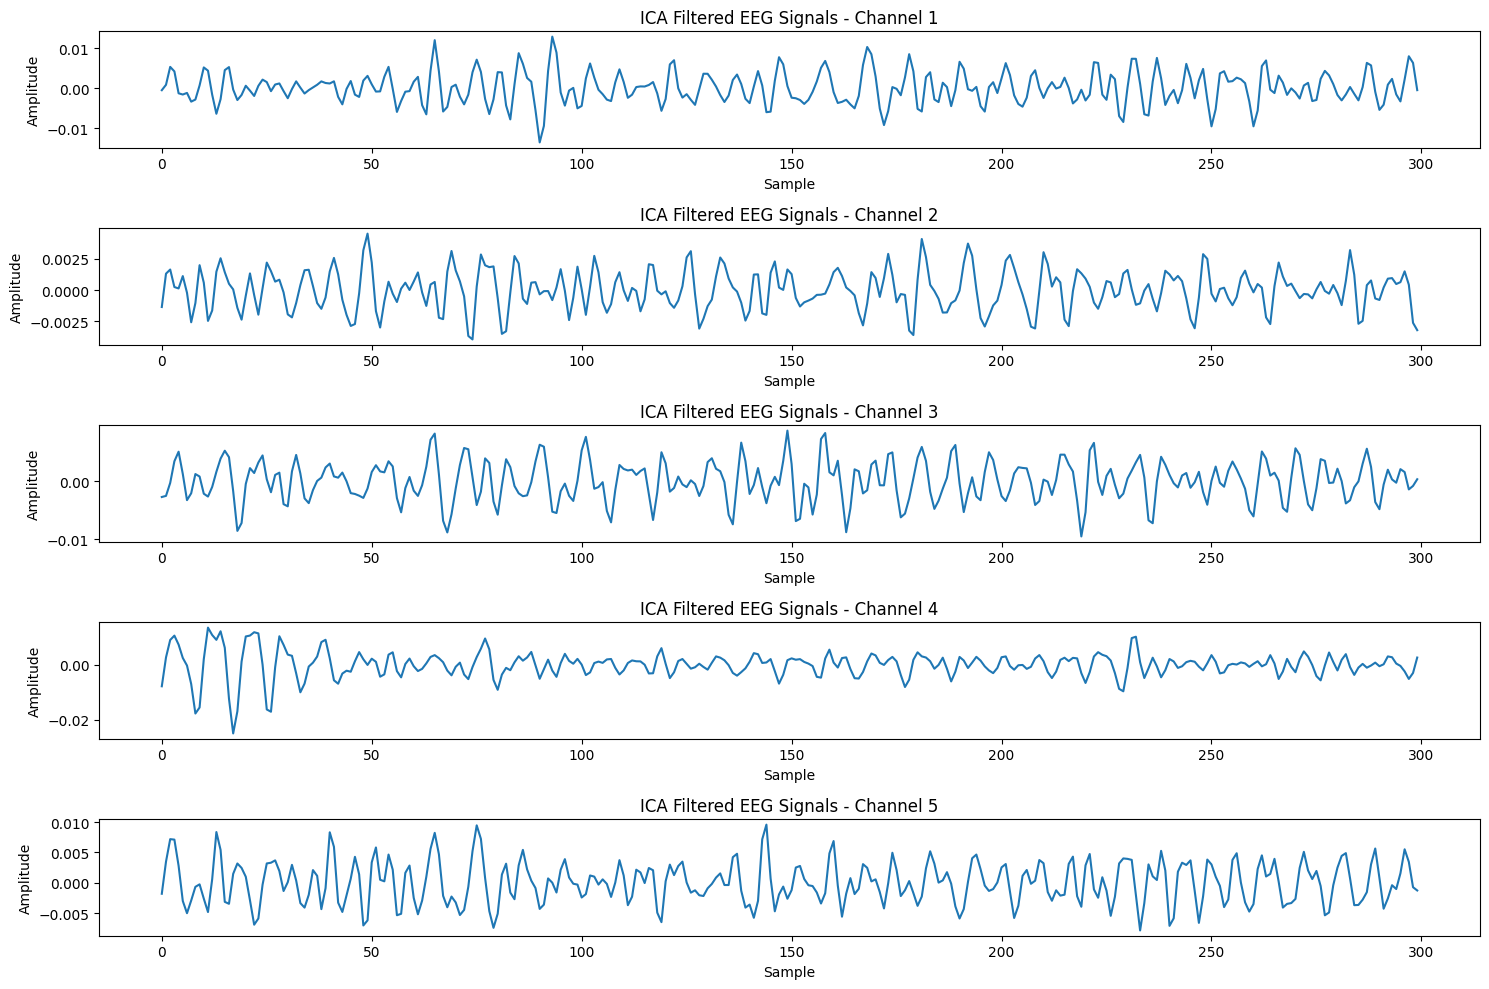

Processing file: /content/drive/MyDrive/ML_Project/BCICIV_1_mat//BCICIV_eval_ds1f.mat


KeyError: 'mrk'

In [ ]:
print(mat_file_paths)

for file_path in mat_file_paths:
    file_path = folder_path + '/' + file_path
    print(f"Processing file: {file_path}")
    process_file(file_path)
